In [1]:
import sys, traceback
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from spectral_cube import LazyMask
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc
from astropy.convolution import Gaussian1DKernel
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic
import os

print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
import radio_beam
from astropy.table import Table

from scipy.optimize import curve_fit
from scipy.optimize import leastsq
#%matplotlib widget
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'
gal="GC"

dist_cmz = 8.178*10**-3*u.Mpc

def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True,beam_size=999,beam_req = 999999,Trunks=True,max_size=18,edge_cases=False):
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX,Distances,V_rms_err = [[],[],[],[]],[[],[],[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    print(metadata)
    
    d_copy= Dendrogram
    #catalog = astrodendro.ppv_catalog(d, metadata)
    if (gal =="GC"):
        center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
        dist_val=8.178*10**3
    else:
        center = SkyCoord('00h47m33.14s' ,'-25d17m17.52s',frame='icrs')
        dist_val=3.5*10**6
    
    center_ra_pix,center_dec_pix = int(metadata['wcsu'][:][:][0].world_to_pixel(center)[0]),int(metadata['wcsu'][:][:][0].world_to_pixel(center)[1])
    
    sliced= LineData[12]
    CubeShape = np.shape(sliced)
    DataShape=[[0,0],[0,0]]#The part of the cube that actually has data

    for lmi in range(CubeShape[0]):
        allData=np.nansum(sliced[lmi])
        if(allData>0 or allData<0):
            DataShape[0][0] = lmi+3
            break
    for lmi in range(CubeShape[0]):
        allData=np.nansum(sliced[CubeShape[0] - lmi -1])
        if(allData>0 or allData<0):
            DataShape[0][1] = CubeShape[0] - lmi -3
            break
    for lmi in range(CubeShape[1]):
        allData=(sliced[DataShape[0][0],lmi])
        if(allData>0 or allData<0):
            DataShape[1][0] = lmi+3
            break
    for lmi in range(CubeShape[1]):
        allData=(sliced[DataShape[0][0],CubeShape[1] - lmi -1])
        if(allData>0 or allData<0):
            DataShape[1][1] = CubeShape[1] - lmi -3
            break
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    
                    if(Trunks):
                        Cont = True
                    else:
                        Cont = False
                else:
                    Cont=True
                    
        for lmi in range(len(I[0])):
            if(I[1][lmi]<=DataShape[0][0] or I[1][lmi]>=DataShape[0][1] or I[2][lmi]<=DataShape[1][0] or I[2][lmi]>=DataShape[1][1]):
                #print(I[1][lmi],I[0][lmi])
                if edge_cases:
                    Cont=True
                else:
                    Cont=False
                break
                

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            s_radius = s.radius
            s_v_rms = s.v_rms
            
            
            if((float((s_radius*np.pi/180*dist_val/10**6/u.deg)))*10**6<max_size and (float((s_radius*np.pi/180*dist_val/10**6/u.deg)))*10**6>beam_size*beam_req and (float(s_v_rms/u.km*u.s))>.01):
            
            

                nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
                v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
                sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 
                
                #The flux from the continuum
                #Convert to Jansky from Jansky per beam:
                if(ColD ==True):
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                    Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s_radius*np.pi/180*dist_cmz.value/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                    
                else:
                    Dust_Column=0
                if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                    Dust_Column=0
                lum = Flux_to_Lum(s.flux)
                s_flux = s.flux

                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 
                
                
                
                
                Distance = np.sqrt((float(s.x_cen/u.pix)-center_ra_pix)**2+(float(s.y_cen/u.pix)- center_dec_pix)**2)*metadata['spatial_scale']*np.pi/180*dist_cmz.value*10**6/u.deg#pc dist from barycenter
                
                
                V_err= Get_V_rms_err(dend1=d_copy,idx=int(t.idx),struct=t,m=m,NF=1,iterations=5,metadata=metadata)
                
                
                if(t.is_leaf):

                    SizeA[0].append((float((s_radius*np.pi/180*dist_val/10**6/u.deg)))) #define size as astrodendro
                    SigmaA[0].append((float(s_v_rms/u.km*u.s)))#
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[0].append(float(Distance))
                    V_rms_err[0].append(float(V_err))
                if(t.is_branch	):

                    SizeA[1].append((float((s_radius*np.pi/180*dist_val/10**6/u.deg)))) #define size as astrodendro
                    SigmaA[1].append((float(s_v_rms/u.km*u.s)))#
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
                    Distances[1].append(float(Distance))
                    V_rms_err[1].append(float(V_err))
                del s
                    
                    
                    
    SizeA[0] = np.array(SizeA[0],dtype=type(1.))
    SizeA[1] = np.array(SizeA[1],dtype=type(1.))
    SizeA[2] = np.array(SizeA[2],dtype=type(1.))
    SizeA[3] = np.array(SizeA[3],dtype=type(1.))
    SigmaA[0] = np.array(SigmaA[0],dtype=type(1.))
    SigmaA[1] = np.array(SigmaA[1],dtype=type(1.))
    SigmaA[2] = np.array(SigmaA[2],dtype=type(1.))
    SigmaA[3] = np.array(SigmaA[3],dtype=type(1.))
    CDA[0] = np.array(CDA[0],dtype=type(1.))
    CDA[1] = np.array(CDA[1],dtype=type(1.))
    LuminA[0] = np.array(LuminA[0],dtype=type(1.))
    LuminA[1] = np.array(LuminA[1],dtype=type(1.))
    SIDS[0] = np.array(SIDS[0],dtype=type(1.))
    SIDS[1] = np.array(SIDS[1],dtype=type(1.))
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0],dtype=type(1.))
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1],dtype=type(1.))
    Distances[0] = np.array(Distances[0],dtype=type(1.))
    Distances[1] = np.array(Distances[1],dtype=type(1.))
    V_rms_err[0] = np.array(V_rms_err[0],dtype=type(1.))
    V_rms_err[1] = np.array(V_rms_err[1],dtype=type(1.))
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX),np.array(Distances),np.array(V_rms_err)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    
    if(gal=="NGC253"):
        pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
        pylab.ylabel('Declination',fontsize=20,labelpad=1)
    else:
        pylab.xlabel('Glon',fontsize=20,labelpad=1)                               
        pylab.ylabel('Glat',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    if(gal=="NGC253"):
        pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
        pylab.ylabel('Declination',fontsize=20,labelpad=1)
    else:
        pylab.xlabel('Glon',fontsize=20,labelpad=1)                               
        pylab.ylabel('Glat',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    if(gal=="NGC253"):
        L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    else:
        L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun #Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    if(gal=="NGC253"):
        L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    else:
        L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L


def Get_V_rms_err(dend1,struct,idx,m,NF,iterations,metadata):
    
    
    vs=[]
    np.random.seed((99)**2*123)
    for llll in range(iterations):
        
        #print(llll)
        s = dend1.__getitem__(idx)
        #s = struct#copy.deepcopy(struct)
        #s2 = struct#copy.deepcopy(struct)
        npixels = np.product(np.shape(s.values()))
        #print(np.shape(s.values()),s.values())
        
        additional_noise = np.random.normal(0., m*NF, npixels)
        additional_noise = np.reshape(additional_noise, np.shape(s.values()))
        #add or subract noise to the values and calculate the v rms, them find the std of that array and
        # call that the uncertainty in v rms for a structure
        dat1P = dend1.data[s.indices()]
        dend1.data[s.indices()]+= additional_noise
        s = dend1.__getitem__(idx)
        vs.append(float(PPVStatistic(s,metadata=metadata).v_rms/u.km*u.s))
        dend1.data[s.indices()]= dat1P#reset the dend data
        
        dend1.data[s.indices()]-= additional_noise
        #s._values+=additional_noise
        #print(s.values(),s._values)
        
        #s2._values-=additional_noise
        s = dend1.__getitem__(idx)
        #print(dat1P[0],s._values[0],"kaasl")
        vs.append(float(PPVStatistic(s,metadata=metadata).v_rms/u.km*u.s))
        
        del s
        #del s2
        
    v_rms_std = np.nanstd(vs)
    #print(v_rms_std)
    return v_rms_std

#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]

    
def Read_Clusters(FileName):
    
    sh= len(np.genfromtxt(FileName,usecols=0))
    Data=[]
    for lmi in range(50):
        try:
            Data.append(np.genfromtxt(FileName,usecols=lmi,dtype=type("2d4m")))
            #print(np.genfromtxt(FileName,usecols=lmi,dtype=type("2d4m"),skip_header=1))
        except:
            pass
    return Data
def Find_Clusters_NGC(Data):
    for lmi in range(len(Data)):
        if "ID" in Data[lmi]:
            IDs= Data[lmi][1:9999]
        if "RA" in Data[lmi]: 
            RAs= Data[lmi][1:9999]
        if "Dec" in Data[lmi]:
            Decs= Data[lmi][1:9999]
        if "r_deconv" in Data[lmi]: 
            R_deconv= Data[lmi][1:9999]#pc
        if "glon" in Data[lmi]: 
            glons= Data[lmi][1:9999]#
        if "glat" in Data[lmi]: 
            glats= Data[lmi][1:9999]#
            
    return IDs,RAs,Decs,R_deconv
#Take the cont in Jy and find the HWHM from the structures in the catalog
def Find_Clusters(Data,wcs,Cont_Data,header):
    for lmi in range(len(Data)):
        if "ID" in Data[lmi]:
            IDs= Data[lmi][1:9999]
        if "RA" in Data[lmi]: 
            RAs= Data[lmi][1:9999]
        if "Dec" in Data[lmi]:
            Decs= Data[lmi][1:9999]
        if "r_deconv" in Data[lmi]: 
            R_deconv= Data[lmi][1:9999]#pc
        if "glon" in Data[lmi]: 
            glons= Data[lmi][1:9999]#
        if "glat" in Data[lmi]: 
            glats= Data[lmi][1:9999]#
        if "herschel_column" in Data[lmi]: 
            CD= (Data[lmi][1:9999])#pc
            
        if "flux_integrated" in Data[lmi]: 
            Flux_1p3mm= Data[lmi][1:9999]#pc
    #remove nan 
    for lmii in range(len(CD)):
        try:
            if CD[lmii]=='np.nan':
                CD= np.delete(CD, lmii)
                Flux_1p3mm= np.delete(Flux_1p3mm, lmii)
                IDs= np.delete(IDs, lmii)
                glats= np.delete(glats, lmii)
                glons= np.delete(glons, lmii)
                
        except:
            CD = np.array(CD,dtype=type(1.2**5))#float
            break
    glats_New=[]
    glons_New=[]
    CDs_New=[]
    IDs_New=[]
    Flux_1p3mm_New=[]

    #print(CD,sorted(CD),type(CD),type(CD[0]))
    nth = sorted(CD)[len(CD)-34]#34 most dense leaves
    #print(nth,"A",CD,sorted(CD))
    for lmj in range(len(CD)):
        if CD[lmj]>nth:
            glats_New.append(glats[lmj])
            glons_New.append(glons[lmj])
            CDs_New.append(CD[lmj])
            IDs_New.append(int(IDs[lmj]))
            Flux_1p3mm_New.append(Flux_1p3mm[lmj])
    HWHM_rad = []      
    #print(Flux_1p3mm_New,glats_New,glons_New,CDs_New,IDs_New)
    for lmi in range(len(CDs_New)):
        glat = glats_New[lmi]
        glon = glons_New[lmi]
        Flux = float(Flux_1p3mm_New[lmi])#INtegerated flux in jy
        
        Circle_R = 0
        distance = 8.178*10**-3*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(l=float(glon)*u.deg, b=float(glat)*u.deg, frame='galactic')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        
        while(True):
            Circle_R += .01
            #pixels=[(p1,p2)]
            pixels=[(p2,p1)]#Goes lat then long for the cont data
            #print(p1,p2)
            #print(np.shape(Cont_Data[p2-50:p2+50]))
            #print(np.shape(Cont_Data[50,p1-50:p1+50]))
            for lmii in range(np.shape(Cont_Data[p2-50:p2+50])[0]):
                for lmjj in range(np.shape(Cont_Data[p2-50+lmii,p1-50:p1+50])[0]):
                    #Find pixels within the circle around the center (excude the center since its there already)
                    #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                    if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                        pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
                        
            
            
            sum_flux=0
            for lmkk in range(len(pixels)):
                sum_flux += (Cont_Data[pixels[lmkk]])
            #print(p1,p2,glat,glon,np.shape(Cont_Data),pixels,Cont_Data[pixels[0]],Flux,sum_flux,Circle_R)
            if sum_flux>Flux/2:
                HWHM_rad.append(Circle_R)#Pc
                break
                
    return HWHM_rad,CDs_New,glons_New,glats_New,IDs_New

#Return masked data around clusters or one pc around clusters
def Mask_Clusters_NGC(HWHM,wcs,header,unmasked_data,ras,decs,One_Pc=False,One_Pc_Size=1,HWHM_Fac=1):
    
    Masked_Data=copy.deepcopy(unmasked_data)
    for lmi in range(len(HWHM)):
        ra = ras[lmi]
        dec = decs[lmi]
                
        Circle_R = HWHM[lmi]*HWHM_Fac
        if(One_Pc):
            
            Circle_R=One_Pc_Size
        distance = 3.5*u.Mpc
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(str(ra),str(dec), frame='icrs')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        


        #pixels=[(p1,p2)]
        pixels=[(p2,p1)]#Goes lat then long for the cont data
        #print(p1,p2)
        #print(np.shape(Cont_Data[p2-50:p2+50]))
        #print(np.shape(Cont_Data[50,p1-50:p1+50]))
        for lmii in range(np.shape(unmasked_data[0,p2-50:p2+50])[0]):
            for lmjj in range(np.shape(unmasked_data[0,p2-50+lmii,p1-50:p1+50])[0]):
                #Find pixels within the circle around the center (excude the center since its there already)
                #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                
                if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                    pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
        
        for lmi in range(len(unmasked_data)):
            
            for lmj in range(len(pixels)):
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
                Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]]=np.nan
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
     
    return Masked_Data
            
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)


def Mask_Clusters_CMZ(HWHM,wcs,header,unmasked_data,glons,glats,One_Pc=False,One_Pc_Size=1,HWHM_Fac=1):
    
    Masked_Data=copy.deepcopy(unmasked_data)
    for lmi in range(len(HWHM)):
        glon = glons[lmi]
        glat = glats[lmi]
                
        Circle_R = HWHM[lmi]*HWHM_Fac
        if(One_Pc):
            
            Circle_R=One_Pc_Size
        distance = dist_cmz
        
        pixel_res = abs(header['cdelt1'])*np.pi/180*distance*10**6/u.Mpc*u.pc # cdelt in deg, goes to res in pc
        
        #sky = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
        sky = SkyCoord(float(glon)*u.deg,float(glat)*u.deg, frame='galactic')
        #center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
        p1,p2 = int(wcs.world_to_pixel(sky)[0]),int(wcs.world_to_pixel(sky)[1]) #Ra,dec
        


        #pixels=[(p1,p2)]
        pixels=[(p2,p1)]#Goes lat then long for the cont data
        #print(p1,p2)
        #print(np.shape(Cont_Data[p2-50:p2+50]))
        #print(np.shape(Cont_Data[50,p1-50:p1+50]))
        for lmii in range(np.shape(unmasked_data[0,p2-50:p2+50])[0]):
            for lmjj in range(np.shape(unmasked_data[0,p2-50+lmii,p1-50:p1+50])[0]):
                #Find pixels within the circle around the center (excude the center since its there already)
                #print(np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res,lmjj)
                
                if np.sqrt((lmii-50)**2+(lmjj-50)**2)*pixel_res.value < Circle_R and lmjj!=50:
                    pixels.append((lmjj-50+p2,lmii-50+p1))#Goes lat then long
        
        for lmi in range(len(unmasked_data)):
            
            for lmj in range(len(pixels)):
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
                Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]]=np.nan
                #print(Masked_Data[lmi,pixels[lmj][0],pixels[lmj][1]],lmi,pixels,np.shape(Masked_Data))
     
    return Masked_Data
            
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)

def Crop_Nans(data):

    sx,sy,ex,ey=0,0,0,0
    for lmi in range(np.shape(data[0,:,:])[0]):

        if(ey!=0 and sx!=0 and ex!=0 and sy!=0):
            print("F",lmi)
            break
        for lmj in range(np.shape(data[0,:,:])[1]):

            if(sx==0):            
                if(np.nanmean(data[0,lmi,:])>0 or np.nanmean(data[0,lmi,:])<0):
                    sx=lmi


            if(sy==0):
                if(np.nanmean(data[0,:,lmj])>0 or np.nanmean(data[0,:,lmj])<0):
                    sy=lmj

            if(ex==0):
                if(np.nanmean(data[0,np.shape(datn[0,:,:])[0]-lmi-1,:])>0 or np.nanmean(data[0,np.shape(data[0,:,:])[0]-lmi-1,:])<0):
                    ex=np.shape(data[0,:,:])[0]-lmi-1

            if(ey==0):
                if(np.nanmean(data[0,:,np.shape(data[0,:,:])[1]-lmj-1])>0 or np.nanmean(data[0,:,np.shape(data[0,:,:])[1]-lmj-1])<0):
                    ey=np.shape(data[0,:,:])[1]-lmj-1

            if(ey!=0 and ex!=0 and sx!=0 and sy!=0):
                break
    print(sx,ex,sy,ey)
    return sx,ex,sy,ey


from astropy.utils import NumpyRNGContext
def gaussian_beam(f, beam_gauss_width):
    '''
    Fourier transform of a Gaussian beam. NOT the power spectrum (multiply exp
    argument by 2 for power spectrum).
    Parameters
    ----------
    f : np.ndarray
        Frequencies to evaluate beam at.
    beam_gauss_width : float
        Beam size. Should be the Gaussian rms, not FWHM.
    '''
    return np.exp(-f**2 * np.pi**2 * 2 * beam_gauss_width**2)

def gauss_correlated_noise_2D(shape, sigma, beam_gauss_width,
                              randomseed=327485749):
    
    '''
    Generate correlated Gaussian noise with sigma, smoothed by a
    Gaussian kernel.
    '''

    # Making a real signal. Only need real part of FFT
    freqs_yy, freqs_xx = np.meshgrid(np.fft.fftfreq(shape[0]),
                                     np.fft.rfftfreq(shape[1]), indexing="ij")

    freqs = np.sqrt(freqs_yy**2 + freqs_xx**2)
    # freqs[freqs == 0.] = np.NaN
    # freqs[freqs == 0.] = 1.

    imsize = shape[0]

    Np1 = (imsize - 1) // 2 if imsize % 2 != 0 else imsize // 2
    
    with NumpyRNGContext(randomseed):

        angles = np.random.uniform(0, 2 * np.pi,
                                   size=freqs.shape)

    noise = np.cos(angles) + 1j * np.sin(angles)

    if imsize % 2 == 0:
        noise[1:Np1, 0] = np.conj(noise[imsize:Np1:-1, 0])
        noise[1:Np1, -1] = np.conj(noise[imsize:Np1:-1, -1])
        noise[Np1, 0] = noise[Np1, 0].real + 1j * 0.0
        noise[Np1, -1] = noise[Np1, -1].real + 1j * 0.0

    else:
        noise[1:Np1 + 1, 0] = np.conj(noise[imsize:Np1:-1, 0])
        noise[1:Np1 + 1, -1] = np.conj(noise[imsize:Np1:-1, -1])

    # Zero freq components must have no imaginary part to be own conjugate
    noise[0, -1] = noise[0, -1].real + 1j * 0.0
    noise[0, 0] = noise[0, 0].real + 1j * 0.0

    corr_field = np.fft.irfft2(noise *
                               gaussian_beam(freqs, beam_gauss_width))

    norm = (np.sqrt(np.sum(corr_field**2)) / np.sqrt(corr_field.size)) / sigma

    corr_field /= norm
    
    return corr_field
restfreq = 345.79598990 * u.GHz

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


In [3]:
#repo func

def Reproject_To_Region(File,Prime_Beam,Line_Name,Gal,ovs,FOV,Force_Origins=False,Force_Value_x=0,Force_Value_y=0):
    
    
    #Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)?
    

    Cube_Name = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+Side+'pc_NEW.fits'
    sc = SpectralCube.read(File)  


    
    #Put in the right system
    sc.allow_huge_operations=True
    vel,RA,Dec = sc.world[:,0,0]




    try:


        sc = sc.spectral_slab(-325. *u.km / u.s, 326. *u.km / u.s)  # Crop out velocities we don't care about  


        HI = sc.header
        Nres=Prime_Beam
        if(gal=="NGC253"):
            dist=3.5*10**6
        if(gal=="GC"):
            dist=8.178*10**3#pc
        res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc

        beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)


        sc.allow_huge_operations=True







        #Now that we have a circular beam, this can be done easily:

        if(gal == 'GC'):

            cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
            cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
            center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
            
            center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])

            PixFov = [int(FOVp[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOVp[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]


            pixels = np.zeros(np.shape(sc))  
            #
            #Find all pixels in the fov
            #
            for lmi in range(np.shape(sc)[0]):
                for lmj in range(np.shape(sc)[1]):
                    for lmk in range(np.shape(sc)[2]):

                        up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                        side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)

                        if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                            
                            pixels[lmi][lmj][lmk] = 1#good
        elif(gal == 'NGC253'):
            #
            #
            #
            pass

            bp = np.where(pixels!=1)

            #Mask teh pixels outside the fov
            scCopy = sc.hdu
            
            scCopy.data[bp]=np.nan
            sc = SpectralCube.read(scCopy)
            del scCopy

        sc.allow_huge_operations=True

        
        try:
            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
        except:
            cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
            cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
            if(cdelt_x>cdelt_y):
                majorBase=cdelt_x
                minorBase=cdelt_y
            elif(cdelt_x<cdelt_y):
                majorBase=cdelt_y
                minorBase=cdelt_x
            elif(cdelt_x==cdelt_y):
                majorBase=cdelt_x
                minorBase=cdelt_x
            BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)

            sc = sc.with_beam(BaseBeam)

            beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
            
            sc.allow_huge_operations=True
            print(sc.shape,np.nanmax(sc.hdu.data),'EA')
            #Requires me to edit convolve.py and set allow_huge =True
            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            
        #
        #prepare a header for the reprojection
        #
        reheader = copy.deepcopy(sc.hdu.header)


        if(gal=="NGC253"):
            ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
            if sc.header['cdelt1']>0:
                pix_x    = (res/ovs).to(u.degree).value
                origin_x = sc.longitude_extrema[0].to(u.degree).value

            else:
                pix_x    = -1.*(res/ovs).to(u.degree).value
                origin_x = (sc.longitude_extrema[1]).to(u.degree).value

            if sc.header['cdelt2']>0:
                pix_y    = (res/ovs).to(u.degree).value
                origin_y = sc.latitude_extrema[0].to(u.degree).value
            else:
                pix_y    = -1.*(res/ovs).to(u.degree).value
                origin_y = sc.latitude_extrema[1].to(u.degree).value

            npix_x   = int(np.ceil(np.diff(sc.longitude_extrema, n=1)[0]/np.abs(pix_x)).value)
            npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)

        elif gal=='GC':
            ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 

            if sc.header['cdelt1']>0:
                
                pix_x    = (res/ovs).to(u.degree).value
                origin_x = sc.longitude_extrema[1].to(u.degree).value 
                if(Force_Origins):
                    
                    origin_x = Force_Value_x[0]#358.6
                    
                

            else:
                
                pix_x    = -(res/ovs).to(u.degree).value
                origin_x = (sc.longitude_extrema[0]).to(u.degree).value 
                
                if(Force_Origins):
                    origin_x = Force_Value_x[1]#.9

            if sc.header['cdelt2']>0:
                
                pix_y    = (res/ovs).to(u.degree).value
                origin_y = sc.latitude_extrema[0].to(u.degree).value
                
                if(Force_Origins):
                    
                    origin_y = Force_Value_y[0]#-.6

            else:
                
                pix_y    = -(res/ovs).to(u.degree).value
                origin_y = sc.latitude_extrema[1].to(u.degree).value
                
                if(Force_Origins):
                    
                    origin_y = Force_Value_y[1]#.6



            if gal=='GC':
                #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
                print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
                print("MA",sc.latitude_extrema,np.abs(pix_y))
                npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
                npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
                if(Force_Origins):
                    npix_x   =int(np.diff(Force_Value_x)/np.abs(pix_x))
                    npix_y   =int(np.diff(Force_Value_y)/np.abs(pix_y))

                print(npix_x,npix_y)


        #Correct the header to the expected pixels for the new res

        reheader['cdelt1'] = pix_x
        reheader['cdelt2'] = pix_y

        reheader['naxis1'] = npix_x
        reheader['naxis2'] = npix_y

        reheader['crval1'] = origin_x
        reheader['crval2'] = origin_y

        reheader['crpix1'] = 0
        reheader['crpix2'] = 0
        
        reheader['CTYPE1'] = "GLON-SIN"
        reheader['CTYPE2'] = "GLAT-SIN"
        try:
            del reheader['lonpole']
            del reheader['latpole']
            del reheader['wcsaxes']#Dont need these anymore, maybe?
            
            del reheader['LBOUND1']
            del reheader['LBOUND2']
            del reheader['LBOUND3']
            del reheader.cards['LBOUND1']
            del reheader.cards['LBOUND2']
            del reheader.cards['LBOUND3']
            
            reheader['LBOUND1']=0
            reheader['LBOUND2']=0
            reheader['LBOUND3']=0
            
            print("12312412")
        except Exception as e:
            print(e)
            
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)
        
        # regrid cube to target pixel size
        
                
        sc2 = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
        del sc
        
        new = SpectralCube(data=sc2.hdu.data,wcs =WCS(sc2.header),header=sc2.header,mask=sc2.mask)
        new.allow_huge_operations=True
        new = new*sc2[0][0][0].unit
        #do this because scs dont like being modified
        del sc2
        sc2 = new
        del new

        print(np.nanmax(sc2),np.shape(sc2))#These should be a non zero float and the shape of the cube (30,~1000,~1000)
        

        Repo_Cube = sc2
        del sc2
        Repo_Cube.allow_huge_operations=True

        #do this again to crop the extra pixels off

        sc=Repo_Cube

        


        #Write the intermediary cubes that will then be spliced together
        #or not
        del Repo_Cube
        
        return sc

    except Exception as e:
        print(e)
        print(kl)
        print("Failed")
        print("-"*60)
        traceback.print_exc(file=sys.stdout)

# Part 1: Updates

In [2]:

#!py -m pip uninstall astropy
#!py -m pip install git+https://github.com/astropy/astropy
#!pip install emcee
!pip install corner
    
'''


!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!py -m pip install reproject
!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git 
!py -m pip install pyspeckit
!py -m pip install regions
!py -m pip install astrodendro
!py -m pip  install wcsaxes 
!py -m pip  install ipympl
!py -m pip install dask
!py -m pip install radio_beam
!py -m pip install casa_formats_io
#try:
#    !pip install casa_formats_io --no-binary :all:
#except:
#    !pip install casa_formats_io --no-cache --no-binary :all:

!py -m pip  install spectral_cube 
!py -m pip  install typing 
!py -m pip install mypy
!py -m pip  install typing_extensions 
'''

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


'\n\n\n!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git\n!py -m pip install reproject\n!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git \n!py -m pip install pyspeckit\n!py -m pip install regions\n!py -m pip install astrodendro\n!py -m pip  install wcsaxes \n!py -m pip  install ipympl\n!py -m pip install dask\n!py -m pip install radio_beam\n!py -m pip install casa_formats_io\n#try:\n#    !pip install casa_formats_io --no-binary :all:\n#except:\n#    !pip install casa_formats_io --no-cache --no-binary :all:\n\n!py -m pip  install spectral_cube \n!py -m pip  install typing \n!py -m pip install mypy\n!py -m pip  install typing_extensions \n'

# Part 6: Reprojection

In [2]:
#Fix header
files = ["12CO_GC_359-000_mosaic.fit"]
#files=["Pre-Smoothed.fits"]



sc = SpectralCube.read(files[0])  
Cube_Name = files[0]+"Header_Fix.fits"
print(1)
sc.allow_huge_operations=True
sc = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio").to(u.K) # Change units from Hz to km/s
new = SpectralCube(data=sc.hdu.data,wcs =WCS(sc.header),mask=sc.mask)
new.allow_huge_operations=True
new=new*sc[0][0][0].unit
print(2)
del sc
sc=new
print(3)
del new

sc.write(Cube_Name,overwrite=True)
print(4)
print("done")

1
2
3
4
done


In [3]:
#Just Using CO 3-2 right now

files = ["12CO_GC_359-000_mosaic.fit"+"Header_Fix.fits"]

#files=["Pre-Smoothed.fits"]
      
#FOV = [400,800]#pc
FOV = [70,360]#pc
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 6
Line_Name = '_CMZ_CO_J3_2_4.3_start'
Side="RH"
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
#Beam_Sizes = np.linspace(Smallest_beam,Smallest_beam*iterations, np.diff(Smallest_beam,Smallest_beam*iterations)/iterations)
iter_factor = 1/5

Initial_vel=1
    
    
for kl in range(5,6):
    Prime_Beam = Min_res*((kl*iter_factor+1))#Beam_Sizes[kl]
    Smoothe_4 = False
    Match_to_HCO = False

    Smoothe_2_5 =False
    
    if(kl==5):
        Prime_Beam = 3*u.pc#Nico
        ovs=5
        FOVp=[200,800]
        Smoothe_2_5=True
        Force_Origins=True
        Force_Value_x=[358.6,.9]
        Force_Value_y=[-.6,.6]
    else:
        ovs=3
        FOVp=FOV
    if(Smoothe_2_5):
        Smoothe_title="Smoothe_to_2.5"
    elif(Smoothe_4):
        Smoothe_title="G_width_4"
    elif(Match_to_HCO):
        Smoothe_title='Smoothe_to_3.3'
    else:
        Smoothe_title=''
    
    #Reproject using the function
    sc =  Reproject_To_Region(File=files[0],Prime_Beam=Prime_Beam,Line_Name=Line_Name,Gal="GC",ovs=ovs,FOV=FOVp,Force_Origins=Force_Origins,Force_Value_x=Force_Value_x,Force_Value_y=Force_Value_y)
                            
    for km in range(5,6):
        scWsc_copy = sc
        vel_prime = min_vel*((km*iter_factor+1))
        if(km==5):
            if(Smoothe_2_5):
                vel_prime=2.5
            else:
                vel_prime=3.3

        Cube_Name_Save = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+Side+'_vel_res_NEW'+Smoothe_title+'.fits'
        if(gal=="GC"):
            vel = np.arange(-300,301,vel_prime)*u.km/u.s    
        elif gal=="NGC253":
            vel = np.arange(-100,601,vel_prime)*u.km/u.s    

        
        if(Smoothe_2_5):
            #G_width = 4
            G_width = np.sqrt(2.5**2-Initial_vel**2)
        if(Match_to_HCO):
            G_width = np.sqrt(3.3**2-Initial_vel**2)
        if(Smoothe_4):
            G_width = 4
        

        scWsc_copy = scWsc_copy.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

        if(Smoothe_2_5):
            scWsc_copy = scWsc_copy.with_spectral_unit(u.km / u.s, velocity_convention='optical', rest_value=restfreq)
        scWsc_copy = scWsc_copy.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range  



        scWsc_copy.write(Cube_Name_Save,overwrite=True)
        gc.collect()
        #scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32.fits",overwrite=True)
    del scWsc_copy

    del sc

    gc.collect()######################################################################



      
    
print("done")         

5
0.030126174114239904 deg A
297 558
<SkyCoord (Galactic): (l, b) in deg
    (0.37990803, 0.38827331)> 297 558
Beam: BMAJ=6.000000000066 arcsec BMIN=6.00000000000948 arcsec BPA=0.0 deg Beam: BMAJ=108.45422681126365 arcsec BMIN=108.45422681126365 arcsec BPA=0.0 deg C
(652, 650, 1250) 39.529446 EA
0.0 0.0
0.0009048085889836596 0.000904808588983712
(652, 650, 1250) B
LA 0.8748042502069521 deg -1.2064667459702036 deg 0.010042058038079968
MA [-0.54161594  0.53985612] deg 0.010042058038079968
229 119
"Keyword 'LBOUND1' not found."
Failed
------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_2048133/3232704202.py", line 280, in <module>
    del reheader['LBOUND1']
  File "/home/ben/.local/lib/python3.8/site-packages/astropy/io/fits/header.py", line 239, in __delitem__
    raise KeyError(f"Keyword '{key}' not found.")
KeyError: "Keyword 'LBOUND1' not found."
22.3608564190813 (652, 119, 229)
done


In [3]:
#Just Using CO 3-2 right now

files = ["12CO_GC_001-002_mosaic.fit"]
#files=["Pre-Smoothed.fits"]



sc = SpectralCube.read(files[0])  
Cube_Name = files[0]+"Header_Fix.fits"
print(1)
sc.allow_huge_operations=True
sc = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio").to(u.K) # Change units from Hz to km/s
new = SpectralCube(data=sc.hdu.data,wcs =WCS(sc.header),mask=sc.mask)
new.allow_huge_operations=True
new=new*sc[0][0][0].unit
print(2)
del sc
sc=new
print(3)
del new

sc.write(Cube_Name,overwrite=True)
print(4)
print("done")

1
2
3
4
done


In [4]:
#print(np.shape(bp))
#np.savetxt("bp.txt",np.array(bp[1][999999:9999999],dtype=int))
#np.savetxt("bp2.txt",np.array(bp[2][0:99999],dtype=int))
#Just Using CO 3-2 right now
#files = ["12CO_GC_359-000_mosaic.fit"]
files = ["12CO_GC_001-002_mosaic.fit"]
files = [files[0]+"Header_Fix.fits"]
      
#files=["Pre-Smoothed.fits"]
      
#FOV = [400,800]#pc
FOV = [70,360]#pc
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 6
Line_Name = '_CMZ_CO_J3_2_4.3_start'
Side="LH"
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
#Beam_Sizes = np.linspace(Smallest_beam,Smallest_beam*iterations, np.diff(Smallest_beam,Smallest_beam*iterations)/iterations)
iter_factor = 1/5
Smoothe_4 = False
Match_to_HCO = True
if(Smoothe_4):
    Smoothe_title="G_width_4"
else:
    Smoothe_title=''
    if(Match_to_HCO):
        Smoothe_title='Smoothe_to_3.3'
Smoothe_2_5 =False
if(Smoothe_2_5):
    Smoothe_title="Smoothe_to_2.5"
    
    
for kl in range(5,6):
    Prime_Beam = Min_res*((kl*iter_factor+1))#Beam_Sizes[kl]
    if(kl==5):
        Prime_Beam = 3*u.pc#Nico
        ovs=5
        FOVp=[200,800]
        if(Match_to_HCO):
            FOVp=[70,360]
            ovs=3
            Prime_Beam = 4.3*u.pc#Nico
    else:
        ovs=3
        FOVp=FOV
    #Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
    

    print(kl)
    Cube_Name = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+Side+'pc_NEW.fits'
    sc = SpectralCube.read(files[0])  


    Nres=4.3*u.pc
    dist=8.178*10**3#pc
    res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
    print(res,"A")



    sc = sc[:,:,:]# Make a subcube

    
    #Put in the right system
    sc.allow_huge_operations=True
    sc_kms = sc#.with_spectral_unit(u.km/u.s,velocity_convention="radio").to(u.K) # Change units from Hz to km/s

    vel,RA,Dec = sc_kms.world[:,0,0]




    try:


        sc = sc_kms.spectral_slab(-325. *u.km / u.s, 326. *u.km / u.s)  # Crop out velocities we don't care about  

        del sc_kms

        HI = sc.header
        Nres=Prime_Beam
        if(gal=="NGC253"):
            dist=3.5*10**6
        if(gal=="GC"):
            dist=8.178*10**3#pc
        res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc

        beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)


        sc.allow_huge_operations=True







        #Now that we have a circular beam, this can be done easily:

        if(gal == 'GC'):

            cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
            cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
            #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
            center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
            center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])

            print(center_dec_pix,center_ra_pix)

            print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
            PixFov = [int(FOVp[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOVp[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]


            pixels = np.zeros(np.shape(sc))           
            for lmi in range(np.shape(sc)[0]):
                for lmj in range(np.shape(sc)[1]):
                    for lmk in range(np.shape(sc)[2]):

                        up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                        side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)

                        if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                            #print(lmj,lmk,np.shape(sc))
                            pixels[lmi][lmj][lmk] = 1#good
                    #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

            bp = np.where(pixels!=1)
            #print(pixels)

            #Mask teh pixels outside the fov
            scCopy = sc.hdu
            #sc.hdu.data[bp]=9999#np.nan
            scCopy.data[bp]=np.nan
            sc = SpectralCube.read(scCopy)
            del scCopy

        sc.allow_huge_operations=True

        
        try:
            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
        except:
            cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
            cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
            if(cdelt_x>cdelt_y):
                majorBase=cdelt_x
                minorBase=cdelt_y
            elif(cdelt_x<cdelt_y):
                majorBase=cdelt_y
                minorBase=cdelt_x
            elif(cdelt_x==cdelt_y):
                majorBase=cdelt_x
                minorBase=cdelt_x
            BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)

            sc = sc.with_beam(BaseBeam)

            beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
            print(BaseBeam,beam,"C")
            sc.allow_huge_operations=True
            print(sc.shape,np.nanmax(sc.hdu.data),'EA')
            #Requires me to edit convolve.py and set allow_huge =True
            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            print(np.shape(sc),"B")












        reheader = copy.deepcopy(sc.hdu.header)


        if(gal=="NGC253"):
            ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
            if sc.header['cdelt1']>0:
                pix_x    = (res/ovs).to(u.degree).value
                origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

            else:
                pix_x    = -1.*(res/ovs).to(u.degree).value
                origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

            if sc.header['cdelt2']>0:
                pix_y    = (res/ovs).to(u.degree).value
                origin_y = sc.latitude_extrema[0].to(u.degree).value
            else:
                pix_y    = -1.*(res/ovs).to(u.degree).value
                origin_y = sc.latitude_extrema[1].to(u.degree).value

            if gal=='NGC253':
                npix_x   = int(np.ceil(np.diff(sc.longitude_extrema, n=1)[0]/np.abs(pix_x)).value)
                npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)

        elif gal=='GC':
            ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 

            if sc.header['cdelt1']>0:
                #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
                pix_x    = (res/ovs).to(u.degree).value
                origin_x = 358.5#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_x    = .55/3*res.to(u.degree).value
                    origin_x = 358.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                    
                #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

            else:
                #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
                pix_x    = -(res/ovs).to(u.degree).value
                origin_x = 1.5#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_x    = -.55/3*res.to(u.degree).value
                    origin_x = .9

            if sc.header['cdelt2']>0:
                #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
                pix_y    = (res/ovs).to(u.degree).value
                origin_y = -.5#sc.latitude_extrema[0].to(u.degree).value
                #origin_y = sc.latitude_extrema[0].to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_y    = .55/3*res.to(u.degree).value
                    origin_y = -0.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

            else:
                #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
                pix_y    = -(res/ovs).to(u.degree).value
                origin_y = .5#sc.latitude_extrema[1].to(u.degree).value
                #origin_y = sc.latitude_extrema[1].to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_y    = -.55/3*res.to(u.degree).value
                    origin_y = 0.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value



            if gal=='GC':
                #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
                print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
                print("MA",sc.latitude_extrema,np.abs(pix_y))
                #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
                #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
                npix_x   =int(2.5/np.abs(pix_x))
                npix_y   =int(1.2/np.abs(pix_y))
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    npix_x   =int(2.3/np.abs(pix_x))
                    npix_y   =int(1.2/np.abs(pix_y))

                print(npix_x,npix_y)


        #Correct the header to the expected pixels for the new res

        reheader['cdelt1'] = pix_x
        reheader['cdelt2'] = pix_y

        reheader['naxis1'] = npix_x
        reheader['naxis2'] = npix_y

        reheader['crval1'] = origin_x
        reheader['crval2'] = origin_y

        reheader['crpix1'] = 0
        reheader['crpix2'] = 0
        
        reheader['CTYPE1'] = "GLON-SIN"
        reheader['CTYPE2'] = "GLAT-SIN"
        try:
            del reheader['lonpole']
            del reheader['latpole']
            del reheader['wcsaxes']#Dont need these anymore, maybe?
            
            del reheader['LBOUND1']
            del reheader['LBOUND2']
            del reheader['LBOUND3']
            del reheader.cards['LBOUND1']
            del reheader.cards['LBOUND2']
            del reheader.cards['LBOUND3']
            
            reheader['LBOUND1']=0
            reheader['LBOUND2']=0
            reheader['LBOUND3']=0
            
            print("12312412")
        except Exception as e:
            print(e)
            
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)
        
        # regrid cube to target pixel size
        
        
        
        #Cube_Name_Load_HCN = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+'_CMZ_HCN_J1_0_4.3_start'+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(3.3)+'_vel_res.fits'
        #del reheader
        #reheader = SpectralCube.read(Cube_Name_Load_HCN).hdu.header
        #reheader["CTYPE3"] = "VRAD"
        
        sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
        del sc
        #new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
        new = SpectralCube(data=sc_K_kms.hdu.data,wcs =WCS(sc_K_kms.header),header=sc_K_kms.header,mask=sc_K_kms.mask)
        new.allow_huge_operations=True
        new = new*sc_K_kms[0][0][0].unit
        #do this because scs dont like being modified
        del sc_K_kms
        sc_K_kms = new
        del new

        print(np.nanmax(sc_K_kms),np.shape(sc_K_kms))#These should be a non zero float and the shape of the cube (30,~1000,~1000)
        

        NGC_CO_J3_2 = sc_K_kms
        del sc_K_kms
        NGC_CO_J3_2.allow_huge_operations=True

        #do this again to crop the extra pixels off

        sc=NGC_CO_J3_2

        


        #Write the intermediary cubes that will then be spliced together
        del NGC_CO_J3_2
        

        

        fwhm_factor = np.sqrt(8*np.log(2))

        vel,RA,Dec =sc.world[:,0,0]
        for km in range(5,6):
            scWsc_copy = sc
            vel_prime = min_vel*((km*iter_factor+1))
            if(km==5):
                if(Smoothe_2_5):
                    vel_prime=2.5
                else:
                    vel_prime=3.3
                
            Cube_Name_Save = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+Side+'_vel_res_NEW'+Smoothe_title+'.fits'
            if(gal=="GC"):
                vel = np.arange(-300,301,vel_prime)*u.km/u.s    
            else:
                vel = np.arange(0,501,vel_prime)*u.km/u.s    

            G_width = np.sqrt(2.5**2-1**2)
            if(km==5):
                #G_width = 4
                G_width = np.sqrt(2.5**2-1**2)
                if(Match_to_HCO):
                    G_width = np.sqrt(3.3**2-1**2)
            if(km==5 and Smoothe_4):
                G_width = 4
            if(km==5 and Smoothe_2_5):
                G_width = 2.5/1#G_width = 2.5/1
                
            scWsc_copy = scWsc_copy.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling
            
            if(Smoothe_2_5):
                scWsc_copy = scWsc_copy.with_spectral_unit(u.km / u.s, velocity_convention='optical', rest_value=restfreq)
            scWsc_copy = scWsc_copy.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range  



            scWsc_copy.write(Cube_Name_Save,overwrite=True)
            gc.collect()
            #scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32.fits",overwrite=True)
        del scWsc_copy
        
        del sc
        
        gc.collect()######################################################################
    except Exception as e:
        print(e)
        print(kl)
        print("Failed")
        print("-"*60)
        traceback.print_exc(file=sys.stdout)


      
    
print("done")     

5
0.030126174114239904 deg A
297 1758
<SkyCoord (Galactic): (l, b) in deg
    (2.37926394, 2.38588274)> 297 1758
Beam: BMAJ=5.9999999999958 arcsec BMIN=5.99999999991804 arcsec BPA=0.0 deg Beam: BMAJ=108.45422681126365 arcsec BMIN=108.45422681126365 arcsec BPA=0.0 deg C
(652, 651, 1251) 21.981215 EA
0.0 0.0
0.0009048085889837246 0.0009048085889837966
(652, 651, 1251) B
LA 0.7915479887956428 deg -357.125709183358 deg 0.010042058038079968
MA [-0.54137717  0.54188001] deg 0.010042058038079968
229 119
"Keyword 'LBOUND1' not found."
Failed
------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_2048133/124915369.py", line 284, in <module>
    del reheader['LBOUND1']
  File "/home/ben/.local/lib/python3.8/site-packages/astropy/io/fits/header.py", line 239, in __delitem__
    raise KeyError(f"Keyword '{key}' not found.")
KeyError: "Keyword 'LBOUND1' not found."
12.571519443629214 (652, 119, 229)
done


In [ ]:
#Just Using CO 3-2 right now

files = ["12CO_GC_357-358_mosaic.fit"]
#files=["Pre-Smoothed.fits"]



sc = SpectralCube.read(files[0])  
Cube_Name = files[0]+"Header_Fix.fits"
print(1)
sc.allow_huge_operations=True
sc = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio").to(u.K) # Change units from Hz to km/s
new = SpectralCube(data=sc.hdu.data,wcs =WCS(sc.header),mask=sc.mask)
new.allow_huge_operations=True
new=new*sc[0][0][0].unit
print(2)
del sc
sc=new
print(3)
del new

sc.write(Cube_Name,overwrite=True)
print(4)
print("done")

In [5]:
#print(np.shape(bp))
#np.savetxt("bp.txt",np.array(bp[1][999999:9999999],dtype=int))
#np.savetxt("bp2.txt",np.array(bp[2][0:99999],dtype=int))
#Just Using CO 3-2 right now
#files = ["12CO_GC_359-000_mosaic.fit"]
files = ["12CO_GC_357-358_mosaic.fit"]
files = [files[0]+"Header_Fix.fits"]
      

#files=["Pre-Smoothed.fits"]
      
#FOV = [400,800]#pc
FOV = [70,360]#pc
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 6
Line_Name = '_CMZ_CO_J3_2_4.3_start'
Side="FRH"
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
#Beam_Sizes = np.linspace(Smallest_beam,Smallest_beam*iterations, np.diff(Smallest_beam,Smallest_beam*iterations)/iterations)
iter_factor = 1/5
Smoothe_4 = False
Match_to_HCO = True
if(Smoothe_4):
    Smoothe_title="G_width_4"
else:
    Smoothe_title=''
    if(Match_to_HCO):
        Smoothe_title='Smoothe_to_3.3'
Smoothe_2_5 =False
if(Smoothe_2_5):
    Smoothe_title="Smoothe_to_2.5"
    
    
for kl in range(5,6):
    Prime_Beam = Min_res*((kl*iter_factor+1))#Beam_Sizes[kl]
    if(kl==5):
        Prime_Beam = 3*u.pc#Nico
        ovs=5
        FOVp=[200,800]
        if(Match_to_HCO):
            FOVp=[70,360]
            ovs=3
            Prime_Beam = 4.3*u.pc#Nico
    else:
        ovs=3
        FOVp=FOV
    #Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
    

    print(kl)
    Cube_Name = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+Side+'pc_NEW.fits'
    sc = SpectralCube.read(files[0])  


    Nres=4.3*u.pc
    dist=8.178*10**3#pc
    res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
    print(res,"A")



    sc = sc[:,:,:]# Make a subcube

    
    #Put in the right system
    sc.allow_huge_operations=True
    sc_kms = sc#.with_spectral_unit(u.km/u.s,velocity_convention="radio").to(u.K) # Change units from Hz to km/s

    vel,RA,Dec = sc_kms.world[:,0,0]




    try:


        sc = sc_kms.spectral_slab(-325. *u.km / u.s, 326. *u.km / u.s)  # Crop out velocities we don't care about  

        del sc_kms

        HI = sc.header
        Nres=Prime_Beam
        if(gal=="NGC253"):
            dist=3.5*10**6
        if(gal=="GC"):
            dist=8.178*10**3#pc
        res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc

        beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)


        sc.allow_huge_operations=True







        #Now that we have a circular beam, this can be done easily:

        if(gal == 'GC'):

            cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
            cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
            #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
            center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
            center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])

            print(center_dec_pix,center_ra_pix)

            print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
            PixFov = [int(FOVp[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOVp[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]


            pixels = np.zeros(np.shape(sc))           
            for lmi in range(np.shape(sc)[0]):
                for lmj in range(np.shape(sc)[1]):
                    for lmk in range(np.shape(sc)[2]):

                        up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                        side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)

                        if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                            #print(lmj,lmk,np.shape(sc))
                            pixels[lmi][lmj][lmk] = 1#good
                    #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

            bp = np.where(pixels!=1)
            #print(pixels)

            #Mask teh pixels outside the fov
            scCopy = sc.hdu
            #sc.hdu.data[bp]=9999#np.nan
            scCopy.data[bp]=np.nan
            sc = SpectralCube.read(scCopy)
            del scCopy

        sc.allow_huge_operations=True

        
        try:
            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
        except:
            cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
            cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
            if(cdelt_x>cdelt_y):
                majorBase=cdelt_x
                minorBase=cdelt_y
            elif(cdelt_x<cdelt_y):
                majorBase=cdelt_y
                minorBase=cdelt_x
            elif(cdelt_x==cdelt_y):
                majorBase=cdelt_x
                minorBase=cdelt_x
            BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)

            sc = sc.with_beam(BaseBeam)

            beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
            print(BaseBeam,beam,"C")
            sc.allow_huge_operations=True
            print(sc.shape,np.nanmax(sc.hdu.data),'EA')
            #Requires me to edit convolve.py and set allow_huge =True
            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            print(np.shape(sc),"B")












        reheader = copy.deepcopy(sc.hdu.header)


        if(gal=="NGC253"):
            ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
            if sc.header['cdelt1']>0:
                pix_x    = (res/ovs).to(u.degree).value
                origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

            else:
                pix_x    = -1.*(res/ovs).to(u.degree).value
                origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

            if sc.header['cdelt2']>0:
                pix_y    = (res/ovs).to(u.degree).value
                origin_y = sc.latitude_extrema[0].to(u.degree).value
            else:
                pix_y    = -1.*(res/ovs).to(u.degree).value
                origin_y = sc.latitude_extrema[1].to(u.degree).value

            if gal=='NGC253':
                npix_x   = int(np.ceil(np.diff(sc.longitude_extrema, n=1)[0]/np.abs(pix_x)).value)
                npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)

        elif gal=='GC':
            ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 

            if sc.header['cdelt1']>0:
                #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
                pix_x    = (res/ovs).to(u.degree).value
                origin_x = 358.5#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_x    = .55/3*res.to(u.degree).value
                    origin_x = 358.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                    
                #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

            else:
                #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
                pix_x    = -(res/ovs).to(u.degree).value
                origin_x = 1.5#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_x    = -.55/3*res.to(u.degree).value
                    origin_x = .9

            if sc.header['cdelt2']>0:
                #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
                pix_y    = (res/ovs).to(u.degree).value
                origin_y = -.5#sc.latitude_extrema[0].to(u.degree).value
                #origin_y = sc.latitude_extrema[0].to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_y    = .55/3*res.to(u.degree).value
                    origin_y = -0.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

            else:
                #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
                pix_y    = -(res/ovs).to(u.degree).value
                origin_y = .5#sc.latitude_extrema[1].to(u.degree).value
                #origin_y = sc.latitude_extrema[1].to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_y    = -.55/3*res.to(u.degree).value
                    origin_y = 0.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value



            if gal=='GC':
                #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
                print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
                print("MA",sc.latitude_extrema,np.abs(pix_y))
                #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
                #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
                npix_x   =int(2.5/np.abs(pix_x))
                npix_y   =int(1.2/np.abs(pix_y))
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    npix_x   =int(2.3/np.abs(pix_x))
                    npix_y   =int(1.2/np.abs(pix_y))

                print(npix_x,npix_y)


        #Correct the header to the expected pixels for the new res

        reheader['cdelt1'] = pix_x
        reheader['cdelt2'] = pix_y

        reheader['naxis1'] = npix_x
        reheader['naxis2'] = npix_y

        reheader['crval1'] = origin_x
        reheader['crval2'] = origin_y

        reheader['crpix1'] = 0
        reheader['crpix2'] = 0
        
        reheader['CTYPE1'] = "GLON-SIN"
        reheader['CTYPE2'] = "GLAT-SIN"
        try:
            del reheader['lonpole']
            del reheader['latpole']
            del reheader['wcsaxes']#Dont need these anymore, maybe?
            
            del reheader['LBOUND1']
            del reheader['LBOUND2']
            del reheader['LBOUND3']
            del reheader.cards['LBOUND1']
            del reheader.cards['LBOUND2']
            del reheader.cards['LBOUND3']
            
            reheader['LBOUND1']=0
            reheader['LBOUND2']=0
            reheader['LBOUND3']=0
            
            print("12312412")
        except Exception as e:
            print(e)
            
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)
        
        # regrid cube to target pixel size
        
        
        
        #Cube_Name_Load_HCN = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+'_CMZ_HCN_J1_0_4.3_start'+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(3.3)+'_vel_res.fits'
        #del reheader
        #reheader = SpectralCube.read(Cube_Name_Load_HCN).hdu.header
        #reheader["CTYPE3"] = "VRAD"
        
        sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
        del sc
        #new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
        new = SpectralCube(data=sc_K_kms.hdu.data,wcs =WCS(sc_K_kms.header),header=sc_K_kms.header,mask=sc_K_kms.mask)
        new.allow_huge_operations=True
        new = new*sc_K_kms[0][0][0].unit
        #do this because scs dont like being modified
        del sc_K_kms
        sc_K_kms = new
        del new

        print(np.nanmax(sc_K_kms),np.shape(sc_K_kms))#These should be a non zero float and the shape of the cube (30,~1000,~1000)
        

        NGC_CO_J3_2 = sc_K_kms
        del sc_K_kms
        NGC_CO_J3_2.allow_huge_operations=True

        #do this again to crop the extra pixels off

        sc=NGC_CO_J3_2

        


        #Write the intermediary cubes that will then be spliced together
        del NGC_CO_J3_2
        

        

        fwhm_factor = np.sqrt(8*np.log(2))

        vel,RA,Dec =sc.world[:,0,0]
        for km in range(5,6):
            scWsc_copy = sc
            vel_prime = min_vel*((km*iter_factor+1))
            if(km==5):
                if(Smoothe_2_5):
                    vel_prime=2.5
                else:
                    vel_prime=3.3
                
            Cube_Name_Save = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+Side+'_vel_res_NEW'+Smoothe_title+'.fits'
            if(gal=="GC"):
                vel = np.arange(-300,301,vel_prime)*u.km/u.s    
            else:
                vel = np.arange(0,501,vel_prime)*u.km/u.s    

            G_width = np.sqrt(2.5**2-1**2)
            if(km==5):
                #G_width = 4
                G_width = np.sqrt(2.5**2-1**2)
                if(Match_to_HCO):
                    G_width = np.sqrt(3.3**2-1**2)
            if(km==5 and Smoothe_4):
                G_width = 4
            if(km==5 and Smoothe_2_5):
                G_width = 2.5/1#G_width = 2.5/1
                
            scWsc_copy = scWsc_copy.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling
            
            if(Smoothe_2_5):
                scWsc_copy = scWsc_copy.with_spectral_unit(u.km / u.s, velocity_convention='optical', rest_value=restfreq)
            scWsc_copy = scWsc_copy.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range  



            scWsc_copy.write(Cube_Name_Save,overwrite=True)
            gc.collect()
            #scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32.fits",overwrite=True)
        del scWsc_copy
        
        del sc
        
        gc.collect()######################################################################
    except Exception as e:
        print(e)
        print(kl)
        print("Failed")
        print("-"*60)
        traceback.print_exc(file=sys.stdout)


      
    
print("done")     

5
0.030126174114239904 deg A
297 -643
<SkyCoord (Galactic): (l, b) in deg
    (358.3798242, -1.6124048)> 297 -643
Beam: BMAJ=5.9999999999814 arcsec BMIN=5.99999999995368 arcsec BPA=0.0 deg Beam: BMAJ=108.45422681126365 arcsec BMIN=108.45422681126365 arcsec BPA=0.0 deg C
(652, 651, 1250) 14.11156 EA
0.0 0.0
0.000904808588983738 0.0009048085889837636
(652, 651, 1250) B
LA 356.7932146962193 deg -1.1257091763739027 deg 0.010042058038079968
MA [-0.54141389  0.54184341] deg 0.010042058038079968
229 119
"Keyword 'LBOUND1' not found."
Failed
------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_2048133/2661310211.py", line 285, in <module>
    del reheader['LBOUND1']
  File "/home/ben/.local/lib/python3.8/site-packages/astropy/io/fits/header.py", line 239, in __delitem__
    raise KeyError(f"Keyword '{key}' not found.")
KeyError: "Keyword 'LBOUND1' not found."
5.917589746448888 (652, 119, 229)
done


In [5]:
#Just Using CO 3-2 right now

files = ["12CO_GC_003-005_mosaic.fit"]
#files=["Pre-Smoothed.fits"]



sc = SpectralCube.read(files[0])  
Cube_Name = files[0]+"Header_Fix.fits"
print(1)
sc.allow_huge_operations=True
sc = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio").to(u.K) # Change units from Hz to km/s
new = SpectralCube(data=sc.hdu.data,wcs =WCS(sc.header),mask=sc.mask)
new.allow_huge_operations=True
new=new*sc[0][0][0].unit
print(2)
del sc
sc=new
print(3)
del new

sc.write(Cube_Name,overwrite=True)
print(4)
print("done")

1
2
3
4
done


In [6]:
#print(np.shape(bp))
#np.savetxt("bp.txt",np.array(bp[1][999999:9999999],dtype=int))
#np.savetxt("bp2.txt",np.array(bp[2][0:99999],dtype=int))
#Just Using CO 3-2 right now
#files = ["12CO_GC_359-000_mosaic.fit"]
files = ["12CO_GC_003-005_mosaic.fit"]
files = [files[0]+"Header_Fix.fits"]
      

#files=["Pre-Smoothed.fits"]
      
#FOV = [400,800]#pc
FOV = [70,360]#pc
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 6
Line_Name = '_CMZ_CO_J3_2_4.3_start'
Side="FLRH"
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
#Beam_Sizes = np.linspace(Smallest_beam,Smallest_beam*iterations, np.diff(Smallest_beam,Smallest_beam*iterations)/iterations)
iter_factor = 1/5
Smoothe_4 = False
Match_to_HCO = True
if(Smoothe_4):
    Smoothe_title="G_width_4"
else:
    Smoothe_title=''
    if(Match_to_HCO):
        Smoothe_title='Smoothe_to_3.3'
Smoothe_2_5 =False
if(Smoothe_2_5):
    Smoothe_title="Smoothe_to_2.5"
    
    
for kl in range(5,6):
    Prime_Beam = Min_res*((kl*iter_factor+1))#Beam_Sizes[kl]
    if(kl==5):
        Prime_Beam = 3*u.pc#Nico
        ovs=5
        FOVp=[200,800]
        if(Match_to_HCO):
            FOVp=[70,360]
            ovs=3
            Prime_Beam = 4.3*u.pc#Nico
    else:
        ovs=3
        FOVp=FOV
    #Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
    

    print(kl)
    Cube_Name = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+Side+'pc_NEW.fits'
    sc = SpectralCube.read(files[0])  


    Nres=4.3*u.pc
    dist=8.178*10**3#pc
    res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
    print(res,"A")



    sc = sc[:,:,:]# Make a subcube

    
    #Put in the right system
    sc.allow_huge_operations=True
    sc_kms = sc#.with_spectral_unit(u.km/u.s,velocity_convention="radio").to(u.K) # Change units from Hz to km/s

    vel,RA,Dec = sc_kms.world[:,0,0]




    try:


        sc = sc_kms.spectral_slab(-325. *u.km / u.s, 326. *u.km / u.s)  # Crop out velocities we don't care about  

        del sc_kms

        HI = sc.header
        Nres=Prime_Beam
        if(gal=="NGC253"):
            dist=3.5*10**6
        if(gal=="GC"):
            dist=8.178*10**3#pc
        res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc

        beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)


        sc.allow_huge_operations=True







        #Now that we have a circular beam, this can be done easily:

        if(gal == 'GC'):

            cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
            cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
            #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
            center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
            center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])

            print(center_dec_pix,center_ra_pix)

            print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
            PixFov = [int(FOVp[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOVp[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]


            pixels = np.zeros(np.shape(sc))           
            for lmi in range(np.shape(sc)[0]):
                for lmj in range(np.shape(sc)[1]):
                    for lmk in range(np.shape(sc)[2]):

                        up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                        side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)

                        if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                            #print(lmj,lmk,np.shape(sc))
                            pixels[lmi][lmj][lmk] = 1#good
                    #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

            bp = np.where(pixels!=1)
            #print(pixels)

            #Mask teh pixels outside the fov
            scCopy = sc.hdu
            #sc.hdu.data[bp]=9999#np.nan
            scCopy.data[bp]=np.nan
            sc = SpectralCube.read(scCopy)
            del scCopy

        sc.allow_huge_operations=True

        
        try:
            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
        except:
            cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
            cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
            if(cdelt_x>cdelt_y):
                majorBase=cdelt_x
                minorBase=cdelt_y
            elif(cdelt_x<cdelt_y):
                majorBase=cdelt_y
                minorBase=cdelt_x
            elif(cdelt_x==cdelt_y):
                majorBase=cdelt_x
                minorBase=cdelt_x
            BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)

            sc = sc.with_beam(BaseBeam)

            beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
            print(BaseBeam,beam,"C")
            sc.allow_huge_operations=True
            print(sc.shape,np.nanmax(sc.hdu.data),'EA')
            #Requires me to edit convolve.py and set allow_huge =True
            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            print(np.shape(sc),"B")












        reheader = copy.deepcopy(sc.hdu.header)


        if(gal=="NGC253"):
            ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
            if sc.header['cdelt1']>0:
                pix_x    = (res/ovs).to(u.degree).value
                origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

            else:
                pix_x    = -1.*(res/ovs).to(u.degree).value
                origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

            if sc.header['cdelt2']>0:
                pix_y    = (res/ovs).to(u.degree).value
                origin_y = sc.latitude_extrema[0].to(u.degree).value
            else:
                pix_y    = -1.*(res/ovs).to(u.degree).value
                origin_y = sc.latitude_extrema[1].to(u.degree).value

            if gal=='NGC253':
                npix_x   = int(np.ceil(np.diff(sc.longitude_extrema, n=1)[0]/np.abs(pix_x)).value)
                npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)

        elif gal=='GC':
            ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 

            if sc.header['cdelt1']>0:
                #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
                pix_x    = (res/ovs).to(u.degree).value
                origin_x = 358.5#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_x    = .55/3*res.to(u.degree).value
                    origin_x = 358.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                    
                #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

            else:
                #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
                pix_x    = -(res/ovs).to(u.degree).value
                origin_x = 1.5#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_x    = -.55/3*res.to(u.degree).value
                    origin_x = .9

            if sc.header['cdelt2']>0:
                #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
                pix_y    = (res/ovs).to(u.degree).value
                origin_y = -.5#sc.latitude_extrema[0].to(u.degree).value
                #origin_y = sc.latitude_extrema[0].to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_y    = .55/3*res.to(u.degree).value
                    origin_y = -0.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

            else:
                #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
                pix_y    = -(res/ovs).to(u.degree).value
                origin_y = .5#sc.latitude_extrema[1].to(u.degree).value
                #origin_y = sc.latitude_extrema[1].to(u.degree).value
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    #pix_y    = -.55/3*res.to(u.degree).value
                    origin_y = 0.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value



            if gal=='GC':
                #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
                print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
                print("MA",sc.latitude_extrema,np.abs(pix_y))
                #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
                #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
                npix_x   =int(2.5/np.abs(pix_x))
                npix_y   =int(1.2/np.abs(pix_y))
                if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                    npix_x   =int(2.3/np.abs(pix_x))
                    npix_y   =int(1.2/np.abs(pix_y))

                print(npix_x,npix_y)


        #Correct the header to the expected pixels for the new res

        reheader['cdelt1'] = pix_x
        reheader['cdelt2'] = pix_y

        reheader['naxis1'] = npix_x
        reheader['naxis2'] = npix_y

        reheader['crval1'] = origin_x
        reheader['crval2'] = origin_y

        reheader['crpix1'] = 0
        reheader['crpix2'] = 0
        
        reheader['CTYPE1'] = "GLON-SIN"
        reheader['CTYPE2'] = "GLAT-SIN"
        try:
            del reheader['lonpole']
            del reheader['latpole']
            del reheader['wcsaxes']#Dont need these anymore, maybe?
            
            del reheader['LBOUND1']
            del reheader['LBOUND2']
            del reheader['LBOUND3']
            del reheader.cards['LBOUND1']
            del reheader.cards['LBOUND2']
            del reheader.cards['LBOUND3']
            
            reheader['LBOUND1']=0
            reheader['LBOUND2']=0
            reheader['LBOUND3']=0
            
            print("12312412")
        except Exception as e:
            print(e)
            
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)
        
        # regrid cube to target pixel size
        
        
        
        #Cube_Name_Load_HCN = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+'_CMZ_HCN_J1_0_4.3_start'+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(3.3)+'_vel_res.fits'
        #del reheader
        #reheader = SpectralCube.read(Cube_Name_Load_HCN).hdu.header
        #reheader["CTYPE3"] = "VRAD"
        
        sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
        del sc
        #new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
        new = SpectralCube(data=sc_K_kms.hdu.data,wcs =WCS(sc_K_kms.header),header=sc_K_kms.header,mask=sc_K_kms.mask)
        new.allow_huge_operations=True
        new = new*sc_K_kms[0][0][0].unit
        #do this because scs dont like being modified
        del sc_K_kms
        sc_K_kms = new
        del new

        print(np.nanmax(sc_K_kms),np.shape(sc_K_kms))#These should be a non zero float and the shape of the cube (30,~1000,~1000)
        

        NGC_CO_J3_2 = sc_K_kms
        del sc_K_kms
        NGC_CO_J3_2.allow_huge_operations=True

        #do this again to crop the extra pixels off

        sc=NGC_CO_J3_2

        


        #Write the intermediary cubes that will then be spliced together
        del NGC_CO_J3_2
        

        

        fwhm_factor = np.sqrt(8*np.log(2))

        vel,RA,Dec =sc.world[:,0,0]
        for km in range(5,6):
            scWsc_copy = sc
            vel_prime = min_vel*((km*iter_factor+1))
            if(km==5):
                if(Smoothe_2_5):
                    vel_prime=2.5
                else:
                    vel_prime=3.3
                
            Cube_Name_Save = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+Side+'_vel_res_NEW'+Smoothe_title+'.fits'
            if(gal=="GC"):
                vel = np.arange(-300,301,vel_prime)*u.km/u.s    
            else:
                vel = np.arange(0,501,vel_prime)*u.km/u.s    

            G_width = np.sqrt(2.5**2-1**2)
            if(km==5):
                #G_width = 4
                G_width = np.sqrt(2.5**2-1**2)
                if(Match_to_HCO):
                    G_width = np.sqrt(3.3**2-1**2)
            if(km==5 and Smoothe_4):
                G_width = 4
            if(km==5 and Smoothe_2_5):
                G_width = 2.5/1#G_width = 2.5/1
                
            scWsc_copy = scWsc_copy.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling
            
            if(Smoothe_2_5):
                scWsc_copy = scWsc_copy.with_spectral_unit(u.km / u.s, velocity_convention='optical', rest_value=restfreq)
            scWsc_copy = scWsc_copy.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range  



            scWsc_copy.write(Cube_Name_Save,overwrite=True)
            gc.collect()
            #scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32.fits",overwrite=True)
        del scWsc_copy
        
        del sc
        
        gc.collect()######################################################################
    except Exception as e:
        print(e)
        print(kl)
        print("Failed")
        print("-"*60)
        traceback.print_exc(file=sys.stdout)


      
    
print("done")     

5
0.030126174114239904 deg A
297 3161
<SkyCoord (Galactic): (l, b) in deg
    (4.71330095, 4.71190695)> 297 3161
Beam: BMAJ=6.00000000002352 arcsec BMIN=6.00000000000372 arcsec BPA=0.0 deg Beam: BMAJ=108.45422681126365 arcsec BMIN=108.45422681126365 arcsec BPA=0.0 deg C
(652, 651, 1450) nan EA
0.0 0.0
0.0009048085889836989 0.0009048085889837173
(652, 651, 1450) B
LA 2.7946564029849865 deg -354.79134727373616 deg 0.010042058038079968
MA [-0.54122728  0.54203008] deg 0.010042058038079968
229 119
"Keyword 'LBOUND1' not found."
Failed
------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_2048133/797905988.py", line 285, in <module>
    del reheader['LBOUND1']
  File "/home/ben/.local/lib/python3.8/site-packages/astropy/io/fits/header.py", line 239, in __delitem__
    raise KeyError(f"Keyword '{key}' not found.")
KeyError: "Keyword 'LBOUND1' not found."
nan (652, 119, 229)
done


In [ ]:
#Just Using CO 3-2 right now

files = ["12CO_GC_359-000_mosaic.fit"]
#files=["Pre-Smoothed.fits"]
      
#FOV = [400,800]#pc
FOV = [70,360]#pc
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 5
Line_Name = '_CMZ_CO_J3_2_4.3_start'
Side="RH"
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
#Beam_Sizes = np.linspace(Smallest_beam,Smallest_beam*iterations, np.diff(Smallest_beam,Smallest_beam*iterations)/iterations)
iter_factor = 1/5
for kl in range(iterations):
    Prime_Beam = Min_res*((kl*iter_factor+1))#Beam_Sizes[kl]
    
    #Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
    
    for i in range(0,100):
        print(kl,i)
        Cube_Name = str(Prime_Beam.value)+"pc_beam_"+str(i)+Line_Name+str(FOV[0])+"x"+str(FOV[1])+Side+'pc.fits'
        sc = SpectralCube.read(files[0])  
    

        Nres=4.3*u.pc
        dist=8.178*10**3#pc
        res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
        print(res,"A")



        sc = sc[:,:,:]# Make a subcube

        #sc = sc[i*30:i*30+30,50:400,50:400]# Make a subcube
        #Put in the right system
        sc.allow_huge_operations=True
        sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio").to(u.K) # Change units from Hz to km/s
        
        vel,RA,Dec = sc_kms.world[:,0,0]

        

        
        try:
            
            sc_kms= sc_kms[i*90:i*90+90,:,:]# Make a subcube
            sc = sc_kms.spectral_slab(-350. *u.km / u.s, 351. *u.km / u.s)  # Crop out velocities we don't care about  
            
            del sc_kms
                
            HI = sc.header
            Nres=Prime_Beam
            if(gal=="NGC253"):
                dist=3.5*10**6
            if(gal=="GC"):
                dist=8.178*10**3#pc
            res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
            
            beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
            
            
            sc.allow_huge_operations=True



            



            #Now that we have a circular beam, this can be done easily:
            
            if(gal == 'GC'):

                cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
                cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
                #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
                center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
                center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])

                print(center_dec_pix,center_ra_pix)

                print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
                PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]


                pixels = np.zeros(np.shape(sc))           
                for lmi in range(np.shape(sc)[0]):
                    for lmj in range(np.shape(sc)[1]):
                        for lmk in range(np.shape(sc)[2]):

                            up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                            side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)

                            if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                                #print(lmj,lmk,np.shape(sc))
                                pixels[lmi][lmj][lmk] = 1#good
                        #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

                bp = np.where(pixels!=1)
                #print(pixels)
                
                #Mask teh pixels outside the fov
                scCopy = sc.hdu
                #sc.hdu.data[bp]=9999#np.nan
                scCopy.data[bp]=np.nan
                sc = SpectralCube.read(scCopy)
                del scCopy
            
            sc.allow_huge_operations=True
            
            
            try:
                sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            except:
                cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
                cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
                if(cdelt_x>cdelt_y):
                    majorBase=cdelt_x
                    minorBase=cdelt_y
                elif(cdelt_x<cdelt_y):
                    majorBase=cdelt_y
                    minorBase=cdelt_x
                elif(cdelt_x==cdelt_y):
                    majorBase=cdelt_x
                    minorBase=cdelt_x
                BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)

                sc = sc.with_beam(BaseBeam)

                beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
                print(BaseBeam,beam,"C")
                sc.allow_huge_operations=True
                print(sc.shape,np.nanmax(sc.hdu.data),'EA')
                #Requires me to edit convolve.py and set allow_huge =True
                sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
                print(np.shape(sc),"B")
            
            
            
            








            reheader = sc.header


            if(gal=="NGC253"):
                ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
                if sc.header['cdelt1']>0:
                    pix_x    = (res/ovs).to(u.degree).value
                    origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

                else:
                    pix_x    = -1.*(res/ovs).to(u.degree).value
                    origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

                if sc.header['cdelt2']>0:
                    pix_y    = (res/ovs).to(u.degree).value
                    origin_y = sc.latitude_extrema[0].to(u.degree).value
                else:
                    pix_y    = -1.*(res/ovs).to(u.degree).value
                    origin_y = sc.latitude_extrema[1].to(u.degree).value

                if gal=='NGC253':
                    npix_x   = int(np.ceil(np.diff(sc.longitude_extrema, n=1)[0]/np.abs(pix_x)).value)
                    npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)

            elif gal=='GC':
                ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
                
                if sc.header['cdelt1']>0:
                    #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
                    pix_x    = (res/5.).to(u.degree).value
                    origin_x = 358.5#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                    #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

                else:
                    #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
                    pix_x    = -(res/5.).to(u.degree).value
                    origin_x = 1.5#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                    #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

                if sc.header['cdelt2']>0:
                    #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
                    pix_y    = (res/5.).to(u.degree).value
                    origin_y = -.5#sc.latitude_extrema[0].to(u.degree).value
                    #origin_y = sc.latitude_extrema[0].to(u.degree).value

                else:
                    #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
                    pix_y    = -(res/5.).to(u.degree).value
                    origin_y = .5#sc.latitude_extrema[1].to(u.degree).value
                    #origin_y = sc.latitude_extrema[1].to(u.degree).value



                if gal=='GC':
                    #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
                    print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
                    print("MA",sc.latitude_extrema,np.abs(pix_y))
                    #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
                    #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
                    npix_x   =int(3/np.abs(pix_x))
                    npix_y   =int(1.2/np.abs(pix_y))

                    print(npix_x,npix_y)


            #Correct the header to the expected pixels for the new res

            reheader['cdelt1'] = pix_x
            reheader['cdelt2'] = pix_y

            reheader['naxis1'] = npix_x
            reheader['naxis2'] = npix_y

            reheader['crval1'] = origin_x
            reheader['crval2'] = origin_y

            reheader['crpix1'] = 0
            reheader['crpix2'] = 0
            try:
                del reheader['lonpole']
                del reheader['latpole']
                del reheader['wcsaxes']#Dont need these anymore, maybe?
            except:
                pass

            # regrid cube to target pixel size
            sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)

            new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
            new.allow_huge_operations=True
            new = new*sc_K_kms[0][0][0].unit
            #do this because scs dont like being modified
            del sc_K_kms
            sc_K_kms = new
            del new

            print(np.nanmax(sc_K_kms),np.shape(sc_K_kms))#These should be a non zero float and the shape of the cube (30,~1000,~1000)
            del sc
            
            NGC_CO_J3_2 = sc_K_kms
            del sc_K_kms
            NGC_CO_J3_2.allow_huge_operations=True

            #do this again to crop the extra pixels off
            
            sc=NGC_CO_J3_2

            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            
            
            #Write the intermediary cubes that will then be spliced together
            sc.write((Cube_Name),overwrite=True)      
            del NGC_CO_J3_2
            del sc
            gc.collect()######################################################################
        except Exception as e:
            print(e)
            print(kl,i)
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)



print("done")         

In [ ]:
#print(np.shape(bp))
#np.savetxt("bp.txt",np.array(bp[1][999999:9999999],dtype=int))
#np.savetxt("bp2.txt",np.array(bp[2][0:99999],dtype=int))
#Just Using CO 3-2 right now
#files = ["12CO_GC_359-000_mosaic.fit"]
files = ["12CO_GC_001-002_mosaic.fit"]
#files = ["12CO_GC_001-002_mosaic.fit"]
      
#files=["Pre-Smoothed.fits"]
      
#FOV = [400,800]#pc
FOV = [70,360]#pc
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 5
Line_Name = '_CMZ_CO_J3_2_4.3_start'
Side="LH"
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
#Beam_Sizes = np.linspace(Smallest_beam,Smallest_beam*iterations, np.diff(Smallest_beam,Smallest_beam*iterations)/iterations)
iter_factor = 1/5
#files=["Pre-Smoothed.fits"]

for kl in range(iterations):
    Prime_Beam = Min_res*((kl*iter_factor+1))#Beam_Sizes[kl]
    
    #Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
    
    for i in range(0,100):
        print(kl,i)
        Cube_Name = str(Prime_Beam.value)+"pc_beam_"+str(i)+Line_Name+str(FOV[0])+"x"+str(FOV[1])+Side+'pc.fits'
        sc = SpectralCube.read(files[0])  
    

        Nres=4.3*u.pc
        dist=8.178*10**3#pc
        res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
        print(res,"A")



        sc = sc[:,:,:]# Make a subcube

        #sc = sc[i*30:i*30+30,50:400,50:400]# Make a subcube
        #Put in the right system
        sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s

        vel,RA,Dec = sc_kms.world[:,0,0]

        

        
        try:
            
            sc_kms= sc_kms[i*90:i*90+90,:,:]# Make a subcube
            sc = sc_kms.spectral_slab(-350. *u.km / u.s, 351. *u.km / u.s)  # Crop out velocities we don't care about  
            
            del sc_kms
            sc.allow_huge_operations=True    
            HI = sc.header
            Nres=Prime_Beam
            if(gal=="NGC253"):
                dist=3.5*10**6
            if(gal=="GC"):
                dist=8.178*10**3#pc
            res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
            
            beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
            
            
            sc.allow_huge_operations=True



            



            #Now that we have a circular beam, this can be done easily:
            #use some trig to make a rectangle at 33 deg, and allow pixels inside it.
            if(gal == 'GC'):

                cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
                cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
                #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
                center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
                center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])

                print(center_dec_pix,center_ra_pix)

                print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
                PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]


                pixels = np.zeros(np.shape(sc))           
                for lmi in range(np.shape(sc)[0]):
                    for lmj in range(np.shape(sc)[1]):
                        for lmk in range(np.shape(sc)[2]):

                            up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                            side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)

                            if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                                #print(lmj,lmk,np.shape(sc))
                                pixels[lmi][lmj][lmk] = 1#good
                        #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

                bp = np.where(pixels!=1)
                #print(pixels)
                bp = np.where(pixels!=1)
                #Mask teh pixels outside the fov
                scCopy = sc.hdu
                #sc.hdu.data[bp]=9999#np.nan
                scCopy.data[bp]=np.nan
                sc = SpectralCube.read(scCopy)
                del scCopy
            
            sc.allow_huge_operations=True
            
            '''         #Get right size

            datn = sc.hdu.data
            sx,sy,ex,ey=0,0,0,0
            for lmi in range(np.shape(datn[0,:,:])[0]):

                if(ey!=0 and sx!=0 and ex!=0 and sy!=0):
                    print("F",lmi)
                    break
                for lmj in range(np.shape(datn[0,:,:])[1]):

                    if(sx==0):            
                        if(np.nanmean(datn[0,lmi,:])>0 or np.nanmean(datn[0,lmi,:])<0):
                            sx=lmi


                    if(sy==0):
                        if(np.nanmean(datn[0,:,lmj])>0 or np.nanmean(datn[0,:,lmj])<0):
                            sy=lmj

                    if(ex==0):
                        if(np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])>0 or np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])<0):
                            ex=np.shape(datn[0,:,:])[0]-lmi-1

                    if(ey==0):
                        if(np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])>0 or np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])<0):
                            ey=np.shape(datn[0,:,:])[1]-lmj-1

                    if(ey!=0 and ex!=0 and sx!=0 and sy!=0):
                        break
            print(sx,ex,sy,ey)
            scP = sc[:,sx:ex,sy:ey]
            scP_Hdu=scP.hdu
            zeros=((scP_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            scP_Hdu.data[bp]=np.nan
            sc = SpectralCube.read(scP_Hdu)
            del scP_Hdu
            del zeros
            del scP
            del datn
            '''
            
            
            try:
                sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            except:
                cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
                cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
                if(cdelt_x>cdelt_y):
                    majorBase=cdelt_x
                    minorBase=cdelt_y
                elif(cdelt_x<cdelt_y):
                    majorBase=cdelt_y
                    minorBase=cdelt_x
                elif(cdelt_x==cdelt_y):
                    majorBase=cdelt_x
                    minorBase=cdelt_x
                BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)

                sc = sc.with_beam(BaseBeam)

                beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
                print(BaseBeam,beam,"C")
                sc.allow_huge_operations=True
                print(sc.shape,np.nanmax(sc.hdu.data),'EA')
                #Requires me to edit convolve.py and set allow_huge =True
                sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
                print(np.shape(sc),"B")
            
            
            
            








            reheader = sc.header


            if(gal=="NGC253"):
                ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
                if sc.header['cdelt1']>0:
                    pix_x    = (res/ovs).to(u.degree).value
                    origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

                else:
                    pix_x    = -1.*(res/ovs).to(u.degree).value
                    origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

                if sc.header['cdelt2']>0:
                    pix_y    = (res/ovs).to(u.degree).value
                    origin_y = sc.latitude_extrema[0].to(u.degree).value
                else:
                    pix_y    = -1.*(res/ovs).to(u.degree).value
                    origin_y = sc.latitude_extrema[1].to(u.degree).value

                if gal=='NGC253':
                    npix_x   = int(np.ceil(np.diff(sc.longitude_extrema, n=1)[0]/np.abs(pix_x)).value)
                    npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)

            elif gal=='GC':
                ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
                
                if sc.header['cdelt1']>0:
                    #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
                    pix_x    = (res/5.).to(u.degree).value
                    origin_x = 358.5#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                    #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

                else:
                    #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
                    pix_x    = -(res/5.).to(u.degree).value
                    origin_x = 1.5#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                    #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

                if sc.header['cdelt2']>0:
                    #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
                    pix_y    = (res/5.).to(u.degree).value
                    origin_y = -.5#sc.latitude_extrema[0].to(u.degree).value
                    #origin_y = sc.latitude_extrema[0].to(u.degree).value

                else:
                    #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
                    pix_y    = -(res/5.).to(u.degree).value
                    origin_y = .5#sc.latitude_extrema[1].to(u.degree).value
                    #origin_y = sc.latitude_extrema[1].to(u.degree).value



                if gal=='GC':
                    #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
                    print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
                    print("MA",sc.latitude_extrema,np.abs(pix_y))
                    #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
                    #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
                    npix_x   =int(3/np.abs(pix_x))
                    npix_y   =int(1.2/np.abs(pix_y))

                    print(npix_x,npix_y)


            #Correct the header to the expected pixels for the new res

            reheader['cdelt1'] = pix_x
            reheader['cdelt2'] = pix_y

            reheader['naxis1'] = npix_x
            reheader['naxis2'] = npix_y

            reheader['crval1'] = origin_x
            reheader['crval2'] = origin_y

            reheader['crpix1'] = 0
            reheader['crpix2'] = 0
            try:
                del reheader['lonpole']
                del reheader['latpole']
                del reheader['wcsaxes']#Dont need these anymore, maybe?
            except:
                pass

            # regrid cube to target pixel size
            sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)

            new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
            new.allow_huge_operations=True
            new = new*sc_K_kms[0][0][0].unit
            #do this because scs dont like being modified
            del sc_K_kms
            sc_K_kms = new
            del new

            print(np.nanmax(sc_K_kms),np.shape(sc_K_kms))#These should be a non zero float and the shape of the cube (30,~1000,~1000)
            del sc
            vel = np.arange(0,501,min_vel)*u.km/u.s
            NGC_CO_J3_2 = sc_K_kms
            del sc_K_kms
            NGC_CO_J3_2.allow_huge_operations=True

            #do this again to crop the extra pixels off
            
            sc=NGC_CO_J3_2
            '''
            datn = sc.hdu.data
            sx,sy,ex,ey=0,0,0,0
            for lmi in range(np.shape(datn[0,:,:])[0]):

                if(ey!=0 and sx!=0 and ex!=0 and sy!=0):
                    print("F",lmi)
                    break
                for lmj in range(np.shape(datn[0,:,:])[1]):

                    if(sx==0):            
                        if(np.nanmean(datn[0,lmi,:])>0 or np.nanmean(datn[0,lmi,:])<0):
                            sx=lmi


                    if(sy==0):
                        if(np.nanmean(datn[0,:,lmj])>0 or np.nanmean(datn[0,:,lmj])<0):
                            sy=lmj

                    if(ex==0):
                        if(np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])>0 or np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])<0):
                            ex=np.shape(datn[0,:,:])[0]-lmi-1

                    if(ey==0):
                        if(np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])>0 or np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])<0):
                            ey=np.shape(datn[0,:,:])[1]-lmj-1

                    if(ey!=0 and ex!=0 and sx!=0 and sy!=0):
                        break
            print(sx,ex,sy,ey)
            scP = sc[:,sx:ex,sy:ey]
            scP_Hdu=scP.hdu
            zeros=((scP_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            scP_Hdu.data[bp]=np.nan
            sc = SpectralCube.read(scP_Hdu)
            del scP_Hdu
            del zeros
            del scP
            del datn
            '''
            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            
            
            #Write the intermediary cubes that will then be spliced together
            sc.write((Cube_Name),overwrite=True)      
            del NGC_CO_J3_2
            del sc
            gc.collect()######################################################################
        except Exception as e:
            print(e)
            print(kl,i)
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)



print("done")         

In [ ]:
#print(np.shape(bp))
#np.savetxt("bp.txt",np.array(bp[1][999999:9999999],dtype=int))
#np.savetxt("bp2.txt",np.array(bp[2][0:99999],dtype=int))
#Just Using CO 3-2 right now
#files = ["12CO_GC_359-000_mosaic.fit"]
files = ["12CO_GC_357-358_mosaic.fit"]
#files = ["12CO_GC_001-002_mosaic.fit"]
      

#files=["Pre-Smoothed.fits"]
      
#FOV = [400,800]#pc
FOV = [70,360]#pc
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 5
Line_Name = '_CMZ_CO_J3_2_4.3_start'
Side="FRH"
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
#Beam_Sizes = np.linspace(Smallest_beam,Smallest_beam*iterations, np.diff(Smallest_beam,Smallest_beam*iterations)/iterations)
iter_factor = 1/5
for kl in range(iterations):
    Prime_Beam = Min_res*((kl*iter_factor+1))#Beam_Sizes[kl]
    
    #Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
    
    for i in range(0,100):
        print(kl,i)
        Cube_Name = str(Prime_Beam.value)+"pc_beam_"+str(i)+Line_Name+str(FOV[0])+"x"+str(FOV[1])+Side+'pc.fits'
        sc = SpectralCube.read(files[0])  
    

        Nres=4.3*u.pc
        dist=8.178*10**3#pc
        res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
        print(res,"A")



        sc = sc[:,:,:]# Make a subcube

        #sc = sc[i*30:i*30+30,50:400,50:400]# Make a subcube
        #Put in the right system
        sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s

        vel,RA,Dec = sc_kms.world[:,0,0]

        

        
        try:
            
            sc_kms= sc_kms[i*90:i*90+90,:,:]# Make a subcube
            sc = sc_kms.spectral_slab(-350. *u.km / u.s, 351. *u.km / u.s)  # Crop out velocities we don't care about  
            
            del sc_kms
            sc.allow_huge_operations=True    
            HI = sc.header
            Nres=Prime_Beam
            if(gal=="NGC253"):
                dist=3.5*10**6
            if(gal=="GC"):
                dist=8.178*10**3#pc
            res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
            
            beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
            
            
            sc.allow_huge_operations=True



            



            #Now that we have a circular beam, this can be done easily:
            #use some trig to make a rectangle at 33 deg, and allow pixels inside it.
            if(gal == 'GC'):

                cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
                cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
                #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
                center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
                center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])

                print(center_dec_pix,center_ra_pix)

                print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
                PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]


                pixels = np.zeros(np.shape(sc))           
                for lmi in range(np.shape(sc)[0]):
                    for lmj in range(np.shape(sc)[1]):
                        for lmk in range(np.shape(sc)[2]):

                            up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                            side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)

                            if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                                #print(lmj,lmk,np.shape(sc))
                                pixels[lmi][lmj][lmk] = 1#good
                        #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

                bp = np.where(pixels!=1)
                #print(pixels)
                bp = np.where(pixels!=1)
                #Mask teh pixels outside the fov
                scCopy = sc.hdu
                #sc.hdu.data[bp]=9999#np.nan
                scCopy.data[bp]=np.nan
                sc = SpectralCube.read(scCopy)
                del scCopy
            
            sc.allow_huge_operations=True
            
            '''         #Get right size

            datn = sc.hdu.data
            sx,sy,ex,ey=0,0,0,0
            for lmi in range(np.shape(datn[0,:,:])[0]):

                if(ey!=0 and sx!=0 and ex!=0 and sy!=0):
                    print("F",lmi)
                    break
                for lmj in range(np.shape(datn[0,:,:])[1]):

                    if(sx==0):            
                        if(np.nanmean(datn[0,lmi,:])>0 or np.nanmean(datn[0,lmi,:])<0):
                            sx=lmi


                    if(sy==0):
                        if(np.nanmean(datn[0,:,lmj])>0 or np.nanmean(datn[0,:,lmj])<0):
                            sy=lmj

                    if(ex==0):
                        if(np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])>0 or np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])<0):
                            ex=np.shape(datn[0,:,:])[0]-lmi-1

                    if(ey==0):
                        if(np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])>0 or np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])<0):
                            ey=np.shape(datn[0,:,:])[1]-lmj-1

                    if(ey!=0 and ex!=0 and sx!=0 and sy!=0):
                        break
            print(sx,ex,sy,ey)
            scP = sc[:,sx:ex,sy:ey]
            scP_Hdu=scP.hdu
            zeros=((scP_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            scP_Hdu.data[bp]=np.nan
            sc = SpectralCube.read(scP_Hdu)
            del scP_Hdu
            del zeros
            del scP
            del datn
            '''
            
            
            try:
                sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            except:
                cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
                cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
                if(cdelt_x>cdelt_y):
                    majorBase=cdelt_x
                    minorBase=cdelt_y
                elif(cdelt_x<cdelt_y):
                    majorBase=cdelt_y
                    minorBase=cdelt_x
                elif(cdelt_x==cdelt_y):
                    majorBase=cdelt_x
                    minorBase=cdelt_x
                BaseBeam = radio_beam.Beam(major=majorBase, minor=minorBase, pa=0*u.deg)

                sc = sc.with_beam(BaseBeam)

                beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)
                print(BaseBeam,beam,"C")
                sc.allow_huge_operations=True
                print(sc.shape,np.nanmax(sc.hdu.data),'EA')
                #Requires me to edit convolve.py and set allow_huge =True
                sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
                print(np.shape(sc),"B")
            
            
            
            








            reheader = sc.header


            if(gal=="NGC253"):
                ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
                if sc.header['cdelt1']>0:
                    pix_x    = (res/ovs).to(u.degree).value
                    origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

                else:
                    pix_x    = -1.*(res/ovs).to(u.degree).value
                    origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

                if sc.header['cdelt2']>0:
                    pix_y    = (res/ovs).to(u.degree).value
                    origin_y = sc.latitude_extrema[0].to(u.degree).value
                else:
                    pix_y    = -1.*(res/ovs).to(u.degree).value
                    origin_y = sc.latitude_extrema[1].to(u.degree).value

                if gal=='NGC253':
                    npix_x   = int(np.ceil(np.diff(sc.longitude_extrema, n=1)[0]/np.abs(pix_x)).value)
                    npix_y   = int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)

            elif gal=='GC':
                ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
                
                if sc.header['cdelt1']>0:
                    #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
                    pix_x    = (res/5.).to(u.degree).value
                    origin_x = 358.5#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
                    #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

                else:
                    #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
                    pix_x    = -(res/5.).to(u.degree).value
                    origin_x = 1.5#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
                    #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

                if sc.header['cdelt2']>0:
                    #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
                    pix_y    = (res/5.).to(u.degree).value
                    origin_y = -.5#sc.latitude_extrema[0].to(u.degree).value
                    #origin_y = sc.latitude_extrema[0].to(u.degree).value

                else:
                    #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
                    pix_y    = -(res/5.).to(u.degree).value
                    origin_y = .5#sc.latitude_extrema[1].to(u.degree).value
                    #origin_y = sc.latitude_extrema[1].to(u.degree).value



                if gal=='GC':
                    #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
                    print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
                    print("MA",sc.latitude_extrema,np.abs(pix_y))
                    #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
                    #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
                    npix_x   =int(3/np.abs(pix_x))
                    npix_y   =int(1.2/np.abs(pix_y))

                    print(npix_x,npix_y)


            #Correct the header to the expected pixels for the new res

            reheader['cdelt1'] = pix_x
            reheader['cdelt2'] = pix_y

            reheader['naxis1'] = npix_x
            reheader['naxis2'] = npix_y

            reheader['crval1'] = origin_x
            reheader['crval2'] = origin_y

            reheader['crpix1'] = 0
            reheader['crpix2'] = 0
            try:
                del reheader['lonpole']
                del reheader['latpole']
                del reheader['wcsaxes']#Dont need these anymore, maybe?
            except:
                pass

            # regrid cube to target pixel size
            sc_K_kms = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)

            new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
            new.allow_huge_operations=True
            new = new*sc_K_kms[0][0][0].unit
            #do this because scs dont like being modified
            del sc_K_kms
            sc_K_kms = new
            del new

            print(np.nanmax(sc_K_kms),np.shape(sc_K_kms))#These should be a non zero float and the shape of the cube (30,~1000,~1000)
            del sc
            vel = np.arange(0,501,min_vel)*u.km/u.s
            NGC_CO_J3_2 = sc_K_kms
            del sc_K_kms
            NGC_CO_J3_2.allow_huge_operations=True

            #do this again to crop the extra pixels off
            
            sc=NGC_CO_J3_2
            '''
            datn = sc.hdu.data
            sx,sy,ex,ey=0,0,0,0
            for lmi in range(np.shape(datn[0,:,:])[0]):

                if(ey!=0 and sx!=0 and ex!=0 and sy!=0):
                    print("F",lmi)
                    break
                for lmj in range(np.shape(datn[0,:,:])[1]):

                    if(sx==0):            
                        if(np.nanmean(datn[0,lmi,:])>0 or np.nanmean(datn[0,lmi,:])<0):
                            sx=lmi


                    if(sy==0):
                        if(np.nanmean(datn[0,:,lmj])>0 or np.nanmean(datn[0,:,lmj])<0):
                            sy=lmj

                    if(ex==0):
                        if(np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])>0 or np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])<0):
                            ex=np.shape(datn[0,:,:])[0]-lmi-1

                    if(ey==0):
                        if(np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])>0 or np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])<0):
                            ey=np.shape(datn[0,:,:])[1]-lmj-1

                    if(ey!=0 and ex!=0 and sx!=0 and sy!=0):
                        break
            print(sx,ex,sy,ey)
            scP = sc[:,sx:ex,sy:ey]
            scP_Hdu=scP.hdu
            zeros=((scP_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            scP_Hdu.data[bp]=np.nan
            sc = SpectralCube.read(scP_Hdu)
            del scP_Hdu
            del zeros
            del scP
            del datn
            '''
            sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
            
            
            #Write the intermediary cubes that will then be spliced together
            sc.write((Cube_Name),overwrite=True)      
            del NGC_CO_J3_2
            del sc
            gc.collect()######################################################################
        except Exception as e:
            print(e)
            print(kl,i)
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)



print("done")         

In [5]:

#Splice CO (FRH)


#Splice CO
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 5
Line_Name = '_CMZ_CO_J3_2_4.3_start'
Side="FRH"
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
iter_factor = 1/5


FOV = [70,360]#pc
Min_res=4.3*u.pc#Smallest resolution


for kl in range(iterations):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    print(Prime_Beam)
    
    
        
    First =True   
    Second = False
    for i in range(0,50):
        
        try:
            Cube_Name_Load = str(Prime_Beam.value)+"pc_beam_"+str(i)+Line_Name+str(FOV[0])+"x"+str(FOV[1])+Side+'pc.fits'


            sc=SpectralCube.read((Cube_Name_Load)) 
            
            vel,RA,Dec =sc.world[:,0,0]


            print(np.shape(sc),Cube_Name_Load)
            print(sc.mask,type(sc.mask))




            if First:
                reheader = sc.header
                rewcs = sc.wcs


            print(type(sc))
            if First:
                scW=SpectralCube.read((Cube_Name_Load))      
                mask = scW.mask.include() #Need to create a mask because it doesn't get splcied
                First = False



            if Second:
                Second = False
                scW = np.concatenate((scW[:].hdu.data,sc[:].hdu.data),dtype = type(sc))
                print(type(scW))
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
            else:
                scW = np.concatenate((scW[:],sc.hdu.data[:]),dtype = type(sc))
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))


            print(np.shape(scW))
        except Exception as e:
            print(e)
            print(kl,i)
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)
    def duh(lol):
        gp = np.where(lol!=np.nan)
        lol[gp]=True
        return lol #Anywhere that has data will be unmasked
    reheader["NAXIS3"] = len(scW)
    Full_Mask = LazyMask(function = duh,data = mask, wcs = rewcs)
    scWsc = SpectralCube(data = scW,wcs = rewcs, header = reheader, mask = Full_Mask)#The spliced cube

    scWsc.allow_huge_operations=True
    scWsc = scWsc*sc[0][0][0].unit#Add unit back in
    del sc
    fwhm_factor = np.sqrt(8*np.log(2))

    scWsc.allow_huge_operations=True


    #scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
    #scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
    for km in range(iterations):
        scWsc_copy = scWsc
        vel_prime = min_vel*((km*iter_factor+1))
        Cube_Name_Save = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+Side+'_vel_res.fits'
        if(gal=="GC"):
            vel = np.arange(-300,301,vel_prime)*u.km/u.s    
        else:
            vel = np.arange(0,501,vel_prime)*u.km/u.s    

        G_width = np.sqrt(abs(scWsc.header["CDELT3"]**2-vel_prime**2))
        scWsc_copy = scWsc_copy.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

        scWsc_copy = scWsc_copy.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range 



        scWsc_copy.write(Cube_Name_Save,overwrite=True)
        gc.collect()
        #scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32.fits",overwrite=True)
    del scWsc

print("done")    

4.3 pc
(1, 165, 497) 4.3pc_beam_0_CMZ_CO_J3_2_4.3_start70x360FRHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f28d069d100> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(2, 165, 497)
(51, 165, 497) 4.3pc_beam_1_CMZ_CO_J3_2_4.3_start70x360FRHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f2721a471c0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(53, 165, 497)
(90, 165, 497) 4.3pc_beam_2_CMZ_CO_J3_2_4.3_start70x360FRHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f28d05b21c0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(143, 165, 497)
(90, 165, 497) 4.3pc_beam_3_CMZ_CO_J3_2_4.3_start70x360FRHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f28d852ba90> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(233, 165, 497)
(90, 165, 497) 4.3pc_beam_4_CMZ_CO_J3_2_4.3_start70x360FRHpc.fits
<spectral_cube.mask

In [6]:

#Splice CO (LH)


#Splice CO
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 5
Line_Name = '_CMZ_CO_J3_2_4.3_start'
Side="LH"
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
iter_factor = 1/5


FOV = [70,360]#pc
Min_res=4.3*u.pc#Smallest resolution





for kl in range(iterations):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    print(Prime_Beam)
    
    
        
    First =True   
    Second = False
    for i in range(0,50):
        
        try:
            Cube_Name_Load = str(Prime_Beam.value)+"pc_beam_"+str(i)+Line_Name+str(FOV[0])+"x"+str(FOV[1])+Side+'pc.fits'


            sc=SpectralCube.read((Cube_Name_Load)) 
            
            vel,RA,Dec =sc.world[:,0,0]


            print(np.shape(sc),Cube_Name_Load)
            print(sc.mask,type(sc.mask))




            if First:
                reheader = sc.header
                rewcs = sc.wcs


            print(type(sc))
            if First:
                scW=SpectralCube.read((Cube_Name_Load))      
                mask = scW.mask.include() #Need to create a mask because it doesn't get splcied
                First = False



            if Second:
                Second = False
                scW = np.concatenate((scW[:].hdu.data,sc[:].hdu.data),dtype = type(sc))
                print(type(scW))
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
            else:
                scW = np.concatenate((scW[:],sc.hdu.data[:]),dtype = type(sc))
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))


            print(np.shape(scW))
        except Exception as e:
            print(e)
            print(kl,i)
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)
    def duh(lol):
        gp = np.where(lol!=np.nan)
        lol[gp]=True
        return lol #Anywhere that has data will be unmasked
    reheader["NAXIS3"] = len(scW)
    Full_Mask = LazyMask(function = duh,data = mask, wcs = rewcs)
    scWsc = SpectralCube(data = scW,wcs = rewcs, header = reheader, mask = Full_Mask)#The spliced cube

    scWsc.allow_huge_operations=True
    scWsc = scWsc*sc[0][0][0].unit#Add unit back in
    del sc
    fwhm_factor = np.sqrt(8*np.log(2))

    scWsc.allow_huge_operations=True


    #scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
    #scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
    for km in range(iterations):
        scWsc_copy = scWsc
        vel_prime = min_vel*((km*iter_factor+1))
        Cube_Name_Save = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+Side+'_vel_res.fits'
        if(gal=="GC"):
            vel = np.arange(-300,301,vel_prime)*u.km/u.s    
        else:
            vel = np.arange(0,501,vel_prime)*u.km/u.s    

        G_width = np.sqrt(abs(scWsc.header["CDELT3"]**2-vel_prime**2))
        scWsc_copy = scWsc_copy.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

        scWsc_copy = scWsc_copy.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range 



        scWsc_copy.write(Cube_Name_Save,overwrite=True)
        gc.collect()
        #scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32.fits",overwrite=True)
    del scWsc

print("done")    

4.3 pc
(1, 165, 497) 4.3pc_beam_0_CMZ_CO_J3_2_4.3_start70x360LHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f2721880c40> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(2, 165, 497)
(55, 165, 497) 4.3pc_beam_1_CMZ_CO_J3_2_4.3_start70x360LHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f27219c1ee0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(57, 165, 497)
(90, 165, 497) 4.3pc_beam_2_CMZ_CO_J3_2_4.3_start70x360LHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f2849756640> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(147, 165, 497)
(90, 165, 497) 4.3pc_beam_3_CMZ_CO_J3_2_4.3_start70x360LHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f27219264f0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(237, 165, 497)
(90, 165, 497) 4.3pc_beam_4_CMZ_CO_J3_2_4.3_start70x360LHpc.fits
<spectral_cube.masks.Laz

In [7]:

#Splice CO (RH)


#Splice CO
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 5
Line_Name = '_CMZ_CO_J3_2_4.3_start'
Side="RH"
ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
iter_factor = 1/5


FOV = [70,360]#pc
Min_res=4.3*u.pc#Smallest resolution




for kl in range(iterations):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    print(Prime_Beam)
    
    
        
    First =True   
    Second = False
    for i in range(0,50):
        
        try:
            Cube_Name_Load = str(Prime_Beam.value)+"pc_beam_"+str(i)+Line_Name+str(FOV[0])+"x"+str(FOV[1])+Side+'pc.fits'


            sc=SpectralCube.read((Cube_Name_Load)) 
            
            vel,RA,Dec =sc.world[:,0,0]


            print(np.shape(sc),Cube_Name_Load)
            print(sc.mask,type(sc.mask))




            if First:
                reheader = sc.header
                rewcs = sc.wcs


            print(type(sc))
            if First:
                scW=SpectralCube.read((Cube_Name_Load))      
                mask = scW.mask.include() #Need to create a mask because it doesn't get splcied
                First = False



            if Second:
                Second = False
                scW = np.concatenate((scW[:].hdu.data,sc[:].hdu.data),dtype = type(sc))
                print(type(scW))
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
            else:
                scW = np.concatenate((scW[:],sc.hdu.data[:]),dtype = type(sc))
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))


            print(np.shape(scW))
        except Exception as e:
            print(e)
            print(kl,i)
            print("Failed")
            print("-"*60)
            traceback.print_exc(file=sys.stdout)
    def duh(lol):
        gp = np.where(lol!=np.nan)
        lol[gp]=True
        return lol #Anywhere that has data will be unmasked
    reheader["NAXIS3"] = len(scW)
    Full_Mask = LazyMask(function = duh,data = mask, wcs = rewcs)
    scWsc = SpectralCube(data = scW,wcs = rewcs, header = reheader, mask = Full_Mask)#The spliced cube

    scWsc.allow_huge_operations=True
    scWsc = scWsc*sc[0][0][0].unit#Add unit back in
    del sc
    fwhm_factor = np.sqrt(8*np.log(2))

    scWsc.allow_huge_operations=True


    #scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
    #scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
    for km in range(iterations):
        scWsc_copy = scWsc
        vel_prime = min_vel*((km*iter_factor+1))
        Cube_Name_Save = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(vel_prime)+Side+'_vel_res.fits'
        if(gal=="GC"):
            vel = np.arange(-300,301,vel_prime)*u.km/u.s    
        else:
            vel = np.arange(0,501,vel_prime)*u.km/u.s    

        G_width = np.sqrt(abs(scWsc.header["CDELT3"]**2-vel_prime**2))
        scWsc_copy = scWsc_copy.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

        scWsc_copy = scWsc_copy.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range 



        scWsc_copy.write(Cube_Name_Save,overwrite=True)
        gc.collect()
        #scWsc.write("NGC_Spliced_Reprojected_Whole_CO_32.fits",overwrite=True)
    del scWsc

print("done")    

4.3 pc
(1, 165, 497) 4.3pc_beam_0_CMZ_CO_J3_2_4.3_start70x360RHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f28d06ed2e0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(2, 165, 497)
(76, 165, 497) 4.3pc_beam_1_CMZ_CO_J3_2_4.3_start70x360RHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f28d85207f0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(78, 165, 497)
(90, 165, 497) 4.3pc_beam_2_CMZ_CO_J3_2_4.3_start70x360RHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f271fb780d0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(168, 165, 497)
(90, 165, 497) 4.3pc_beam_3_CMZ_CO_J3_2_4.3_start70x360RHpc.fits
<spectral_cube.masks.LazyMask object at 0x7f27219c0cd0> <class 'spectral_cube.masks.LazyMask'>
<class 'spectral_cube.spectral_cube.SpectralCube'>
(258, 165, 497)
(90, 165, 497) 4.3pc_beam_4_CMZ_CO_J3_2_4.3_start70x360RHpc.fits
<spectral_cube.masks.Laz

In [2]:
#Splice right and left




#Splice CO
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 6
Line_Name = '_CMZ_CO_J3_2_4.3_start'

ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
iter_factor = 1/5


FOV = [70,360]#pc
Min_res=4.3*u.pc#Smallest resolution

Smoothe_4 = False
Match_to_HCO = True
if(Smoothe_4):
    Smoothe_title="G_width_4"
else:
    Smoothe_title=''
    if(Match_to_HCO):
        Smoothe_title='Smoothe_to_3.3'
Smoothe_2_5 =False
if(Smoothe_2_5):
    Smoothe_title="Smoothe_to_2.5"
    
    
if(Line_Name == '_CMZ_CO_J3_2_4.3_start'):

    for kl in range(5,6):
      
        Prime_Beam = Min_res*((kl*iter_factor+1))#
        if(kl==5):
            Prime_Beam = 3*u.pc#Nico
            FOVp=[200,800]
            
            if(Match_to_HCO):
                Prime_Beam = 4.3*u.pc#Nico
                FOVp=[70,360]
            
        else:
            FOVp=FOV
            
        print(Prime_Beam)
    
        for km in range(5,6):
            vel_prime = min_vel*((km*iter_factor+1))
            if(km==5):
                vel_prime=2.5
                ovs=5
            if(Match_to_HCO):
                vel_prime=3.3
                ovs=3
                
            
            Side="LH"
            Cube_Name_Load_LH = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+Side+'_vel_res_NEW'+Smoothe_title+'.fits'
            Side="RH"
            Cube_Name_Load_RH =str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+Side+'_vel_res_NEW'+Smoothe_title+'.fits'
            Side="FRH"
            Cube_Name_Load_FRH = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+Side+'_vel_res_NEW'+Smoothe_title+'.fits'
            Side="FLRH"
            Cube_Name_Load_FLH = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+Side+'_vel_res_NEW'+Smoothe_title+'.fits'

            Cube_Name_Save = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW'+Smoothe_title+'.fits'

            SCR = SpectralCube.read(Cube_Name_Load_RH)
            SCR = SCR.with_spectral_unit(u.km / u.s, velocity_convention='radio', rest_value=restfreq)
            vel,RA,Dec = SCR.world[:,0,0]
            print(vel)
            SCL=SpectralCube.read(Cube_Name_Load_LH)
            SCL = SCL.with_spectral_unit(u.km / u.s, velocity_convention='radio', rest_value=restfreq)
            vel,RA,Dec = SCL.world[:,0,0]
            
            SCFR=SpectralCube.read(Cube_Name_Load_FRH)
            SCFR = SCFR.with_spectral_unit(u.km / u.s, velocity_convention='radio', rest_value=restfreq)
            vel,RA,Dec = SCFR.world[:,0,0]
            
            SCFL=SpectralCube.read(Cube_Name_Load_FLH)
            SCFL = SCFL.with_spectral_unit(u.km / u.s, velocity_convention='radio', rest_value=restfreq)
            vel,RA,Dec = SCFL.world[:,0,0]
            

            print(SCR[0][100][100],SCFR[0][100][100],SCL[0][100][100],SCFL[0][100][100])
           
            
            
            if gal=='GC' and Line_Name=='_CMZ_CO_J3_2_4.3_start' and kl==5:
                reheader = copy.deepcopy(SCFR.hdu.header)
                
                dist=8.178*10**3#pc
                res=  Prime_Beam/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
                ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 

                if reheader['cdelt1']>0:
                    #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
                    pix_x    = (res/ovs).to(u.degree).value
                    origin_x = 357
                    #pix_x    = .55/3*res.to(u.degree).value
               

                else:
                    #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
                    pix_x    = -(res/ovs).to(u.degree).value
                    origin_x = 3
                    #pix_x    = -.55/3*res.to(u.degree).value

                if reheader['cdelt2']>0:
                    #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
                    pix_y    = (res/ovs).to(u.degree).value
                    origin_y = -.5#sc.latitude_extrema[0].to(u.degree).value
                    #origin_y = sc.latitude_extrema[0].to(u.degree).value
                    if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                        #pix_y    = .55/3*res.to(u.degree).value
                        origin_y = -0.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

                else:
                    #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
                    pix_y    = -(res/ovs).to(u.degree).value
                    #pix_y    = -.55/3*res.to(u.degree).value
                    origin_y = .5#sc.latitude_extrema[1].to(u.degree).value
                    #origin_y = sc.latitude_extrema[1].to(u.degree).value
                    origin_y = 0.6#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value



                if gal=='GC':
                    
                    #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
                    #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
                    npix_x   =int(3/np.abs(pix_x))
                    npix_y   =int(1.2/np.abs(pix_y))
                    if(Line_Name == '_CMZ_CO_J3_2_4.3_start' and kl==5):
                        npix_x   =int(6/np.abs(pix_x))
                        npix_y   =int(1.2/np.abs(pix_y))

                    print(npix_x,npix_y)


                #Correct the header to the expected pixels for the new res

                reheader['cdelt1'] = pix_x
                reheader['cdelt2'] = pix_y

                reheader['naxis1'] = npix_x
                reheader['naxis2'] = npix_y

                reheader['crval1'] = origin_x
                reheader['crval2'] = origin_y

                reheader['crpix1'] = 0
                reheader['crpix2'] = 0

                reheader['CTYPE1'] = "GLON-SIN"
                reheader['CTYPE2'] = "GLAT-SIN"
                try:
                    del reheader['lonpole']
                    del reheader['latpole']
                    del reheader['wcsaxes']#Dont need these anymore, maybe?

                    del reheader['LBOUND1']
                    del reheader['LBOUND2']
                    del reheader['LBOUND3']
                    del reheader.cards['LBOUND1']
                    del reheader.cards['LBOUND2']
                    del reheader.cards['LBOUND3']

                    reheader['LBOUND1']=0
                    reheader['LBOUND2']=0
                    reheader['LBOUND3']=0

                    print("12312412")
                except Exception as e:
                    print(e)

                    print("Failed")
                    print("-"*60)
                    traceback.print_exc(file=sys.stdout)


                    # regrid cube to target pixel size



                #Cube_Name_Load_HCN = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+'_CMZ_HCN_J1_0_4.3_start'+str(FOV[0])+"x"+str(FOV[1])+'pc_'+str(3.3)+'_vel_res.fits'
                #del reheader
                #reheader = SpectralCube.read(Cube_Name_Load_HCN).hdu.header
                #reheader["CTYPE3"] = "VRAD"
                
                
                SCR.write("test1.fits",overwrite=True)
                
                SCR.write("test8.fits",overwrite=True)
                SCRN = SCR.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
                SCRN.write("test2.fits",overwrite=True)
                del SCR
                #new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
                SCR = SpectralCube(data=SCRN.hdu.data,wcs =WCS(SCRN.header),header=SCRN.header,mask=SCRN.mask)
                SCR.allow_huge_operations=True
                SCR = SCR*SCRN[0][0][0].unit
                SCR.write("test3.fits",overwrite=True)
                
                del SCRN
                SCLN = SCL.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
                del SCL
                #new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
                SCL = SpectralCube(data=SCLN.hdu.data,wcs =WCS(SCLN.header),header=SCLN.header,mask=SCLN.mask)
                SCL.allow_huge_operations=True
                SCL = SCL*SCLN[0][0][0].unit
                del SCLN
                SCFRN = SCFR.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
                del SCFR
                #new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
                SCFR = SpectralCube(data=SCFRN.hdu.data,wcs =WCS(SCFRN.header),header=SCFRN.header,mask=SCFRN.mask)
                SCFR.allow_huge_operations=True
                SCFR = SCFR*SCFRN[0][0][0].unit
                del SCFRN
                SCFLN = SCFL.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
                del SCFL
                #new = SpectralCube(data=sc_K_kms.hdu.data,wcs = WCS(sc_K_kms.header),header=sc_K_kms.header)
                SCFL = SpectralCube(data=SCFLN.hdu.data,wcs =WCS(SCFLN.header),header=SCFLN.header,mask=SCFLN.mask)
                SCFL.allow_huge_operations=True
                SCFL = SCFL*SCFLN[0][0][0].unit
                del SCFLN
            
            
            
            #Get right shape
            
            datn = SCR.hdu.data
            sx0,ex0,sy0,ey0=Crop_Nans(datn)
            
            SCR = SCR[:,sx0:ex0,:]
            
            SCR_Hdu=SCR.hdu
            zeros=((SCR_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            SCR_Hdu.data[bp]=np.nan
            
            for lmi in range(len(datn)):
                SCR_Hdu.data[lmi,:,sy0-3:sy0+3]=np.nan
                SCR_Hdu.data[lmi,:,ey0-3:ey0+3]=np.nan
                #SCR_Hdu.data[lmi,:,ey:ey]=np.nan
            datn=SCR_Hdu.data
            sx,ex,sy,ey=Crop_Nans(datn)
            
            SCR = SpectralCube.read(SCR_Hdu)
            
            datn = SCL.hdu.data
            sx2,ex2,sy2,ey2=Crop_Nans(datn)
            
            
            
            SCL=SCL[:,sx0:ex0,:]
            
            SCL_Hdu=SCL.hdu
            zeros=((SCL_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            SCL_Hdu.data[bp]=np.nan
            
            for lmi in range(len(datn)):
                #SCL_Hdu.data[lmi,:,sy-5:sy+5]=np.nan
                
                #SCL_Hdu.data[lmi,:,sy2-3:sy2+3]=np.nan
                SCL_Hdu.data[lmi,:,ey2-3:ey2+3]=np.nan
                
                SCL_Hdu.data[lmi,:,ey2:ey]=np.nan
                
            SCL = SpectralCube.read(SCL_Hdu)
            
            
            datn = SCFR.hdu.data
            sx3,ex3,sy3,ey3=Crop_Nans(datn)
            
            
            
            SCFR=SCFR[:,sx0:ex0,:]
            
            SCFR_Hdu=SCFR.hdu
            zeros=((SCFR_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            SCFR_Hdu.data[bp]=np.nan
            
            
            for lmi in range(len(datn)):
                
                SCFR_Hdu.data[lmi,:,sy3-3:sy3+3]=np.nan
                SCFR_Hdu.data[lmi,:,ey3-3:ey3+3]=np.nan
                
                
                SCFR_Hdu.data[lmi,:,sy:sy3]=np.nan
                #SCFR_Hdu.data[lmi,:,ey-5:ey+5]=np.nan#Takes care of the cube edges
                
                
            SCFR = SpectralCube.read(SCFR_Hdu)
                        

            
            
            
            datn = SCFL.hdu.data
            sx4,ex4,sy4,ey4=Crop_Nans(datn)
            
            
            
            SCFL=SCFL[:,sx0:ex0,:]
            
            SCFL_Hdu=SCFL.hdu
            zeros=((SCFL_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            SCFL_Hdu.data[bp]=np.nan
            
            
            for lmi in range(len(datn)):
                pass
                #SCFL_Hdu.data[lmi,:,sy4-3:sy4+3]=np.nan
                #SCFL_Hdu.data[lmi,:,ey4-3:ey4+3]=np.nan
                
                
                #SCFL_Hdu.data[lmi,:,sy2:sy4]=np.nan
                #SCFR_Hdu.data[lmi,:,ey-5:ey+5]=np.nan#Takes care of the cube edges
                
                
            SCFL = SpectralCube.read(SCFL_Hdu)
            #SCR.write("test4.fits",overwrite=True)
            #SCL.write("test5.fits",overwrite=True)
            #SCFR.write("test6.fits",overwrite=True)


            RD = SCR.hdu.data
            LD=SCL.hdu.data
            FRD = SCFR.hdu.data
            FLD = SCFL.hdu.data
            print(np.shape(RD),len(RD))
            print(np.shape(LD))
            print(np.shape(FRD))
            print(np.shape(FLD))
            C = np.copy(LD)
            wcs = SCR.wcs
            header=SCR.hdu.header
            hdu=SCR.hdu
            world=SCR.world


            for lmi in range(len(RD)):
                for lmj in range(len(RD[lmi])):
                    for lmk in range(len(RD[lmi][lmj])):
                        if((RD[lmi][lmj][lmk]> 0 or RD[lmi][lmj][lmk]< 0) and (LD[lmi][lmj][lmk]> 0 or LD[lmi][lmj][lmk]< 0)):
                            C[lmi][lmj][lmk] = np.nanmean([RD[lmi][lmj][lmk],LD[lmi][lmj][lmk]])
                        elif((RD[lmi][lmj][lmk]> 0 or RD[lmi][lmj][lmk]< 0) and (FRD[lmi][lmj][lmk]> 0 or FRD[lmi][lmj][lmk]< 0)):
                            C[lmi][lmj][lmk] = np.nanmean([RD[lmi][lmj][lmk],FRD[lmi][lmj][lmk]])
                        elif((LD[lmi][lmj][lmk]> 0 or LD[lmi][lmj][lmk]< 0) and (FLD[lmi][lmj][lmk]> 0 or FLD[lmi][lmj][lmk]< 0)):
                            C[lmi][lmj][lmk] = np.nanmean([LD[lmi][lmj][lmk],FLD[lmi][lmj][lmk]])
                        elif(RD[lmi][lmj][lmk]>0 or RD[lmi][lmj][lmk]<0):
                            C[lmi][lmj][lmk] =RD[lmi][lmj][lmk]
                        elif(FRD[lmi][lmj][lmk]>0 or FRD[lmi][lmj][lmk]<0):
                            C[lmi][lmj][lmk] =FRD[lmi][lmj][lmk]
                            #print("Ye",lmi,lmj,lmk)
                        elif(LD[lmi][lmj][lmk]>0 or LD[lmi][lmj][lmk]<0):
                            C[lmi][lmj][lmk] =LD[lmi][lmj][lmk]
                        elif(FLD[lmi][lmj][lmk]>0 or FLD[lmi][lmj][lmk]<0):
                            C[lmi][lmj][lmk] =FLD[lmi][lmj][lmk]






                print(np.nanmean(C[lmi]))
                print(lmi)


            Comb = SpectralCube(data=C, wcs=wcs,header=header)
            Comb.allow_huge_operations=True
            Comb = Comb*SCL[0][0][0].unit



            Comb.write(Cube_Name_Save,overwrite=True)
print("done")

4.3 pc
[-3.000e+02 -2.967e+02 -2.934e+02 -2.901e+02 -2.868e+02 -2.835e+02
 -2.802e+02 -2.769e+02 -2.736e+02 -2.703e+02 -2.670e+02 -2.637e+02
 -2.604e+02 -2.571e+02 -2.538e+02 -2.505e+02 -2.472e+02 -2.439e+02
 -2.406e+02 -2.373e+02 -2.340e+02 -2.307e+02 -2.274e+02 -2.241e+02
 -2.208e+02 -2.175e+02 -2.142e+02 -2.109e+02 -2.076e+02 -2.043e+02
 -2.010e+02 -1.977e+02 -1.944e+02 -1.911e+02 -1.878e+02 -1.845e+02
 -1.812e+02 -1.779e+02 -1.746e+02 -1.713e+02 -1.680e+02 -1.647e+02
 -1.614e+02 -1.581e+02 -1.548e+02 -1.515e+02 -1.482e+02 -1.449e+02
 -1.416e+02 -1.383e+02 -1.350e+02 -1.317e+02 -1.284e+02 -1.251e+02
 -1.218e+02 -1.185e+02 -1.152e+02 -1.119e+02 -1.086e+02 -1.053e+02
 -1.020e+02 -9.870e+01 -9.540e+01 -9.210e+01 -8.880e+01 -8.550e+01
 -8.220e+01 -7.890e+01 -7.560e+01 -7.230e+01 -6.900e+01 -6.570e+01
 -6.240e+01 -5.910e+01 -5.580e+01 -5.250e+01 -4.920e+01 -4.590e+01
 -4.260e+01 -3.930e+01 -3.600e+01 -3.270e+01 -2.940e+01 -2.610e+01
 -2.280e+01 -1.950e+01 -1.620e+01 -1.290e+01 -9.600e+00

In [3]:
#Fix the Nans

#Splice CO
gal="GC"
Min_res=4.3*u.pc#Smallest resolution


iterations = 6
Line_Name = '_CMZ_CO_J3_2_4.3_start'

ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
iter_factor = 1/5


FOV = [70,360]#pc
Min_res=4.3*u.pc#Smallest resolution


Smoothe_4 = False
Match_to_HCO = True
if(Smoothe_4):
    Smoothe_title="G_width_4"
else:
    Smoothe_title=''
    if(Match_to_HCO):
        Smoothe_title='Smoothe_to_3.3'
Smoothe_2_5 =False
if(Smoothe_2_5):
    Smoothe_title="Smoothe_to_2.5"
    
if(Line_Name == '_CMZ_CO_J3_2_4.3_start'):

    for kl in range(5,6):
      
        Prime_Beam = Min_res*((kl*iter_factor+1))#
        if(kl==5):
            Prime_Beam = 3*u.pc#Nico
            FOVp=[200,800]
            
            if(Match_to_HCO):
                Prime_Beam = 4.3*u.pc#Nico
                FOVp=[70,360]
            
        else:
            FOVp=FOV
            
        print(Prime_Beam)
    
        for km in range(5,6):
            vel_prime = min_vel*((km*iter_factor+1))
            if(km==5):
                vel_prime=2.5
                ovs=5
            if(Match_to_HCO):
                vel_prime=3.3
                ovs=3
            
            Cube_Name_Save = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW'+Smoothe_title+'.fits'
            Cube_Name_Load = str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW'+Smoothe_title+'.fits'
            
            Cube_Name_Save=str("Cropped_"+Cube_Name_Load)
            print(Cube_Name_Load)
            sc = SpectralCube.read(Cube_Name_Load)
            sc.write("test7.fits",overwrite=True)
            datn = sc.hdu.data
            
            #Get right shape
            sx,sy,ex,ey=0,0,0,0
            for lmi in range(np.shape(datn[0,:,:])[0]):

                if(ey!=0 and sx!=0 and ex!=0 and sy!=0):
                    print("F",lmi)
                    break
                for lmj in range(np.shape(datn[0,:,:])[1]):

                    if(sx==0):            
                        if(np.nanmean(datn[0,lmi,:])>0 or np.nanmean(datn[0,lmi,:])<0):
                            sx=lmi


                    if(sy==0):
                        if(np.nanmean(datn[0,:,lmj])>0 or np.nanmean(datn[0,:,lmj])<0):
                            sy=lmj

                    if(ex==0):
                        if(np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])>0 or np.nanmean(datn[0,np.shape(datn[0,:,:])[0]-lmi-1,:])<0):
                            ex=np.shape(datn[0,:,:])[0]-lmi-1

                    if(ey==0):
                        if(np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])>0 or np.nanmean(datn[0,:,np.shape(datn[0,:,:])[1]-lmj-1])<0):
                            ey=np.shape(datn[0,:,:])[1]-lmj-1

                    if(ey!=0 and ex!=0 and sx!=0 and sy!=0):
                        break
            print(sx,ex,sy,ey)
            
            
            sc = sc[:,sx:ex,sy:ey]
            
            sc_Hdu=sc.hdu
            zeros=((sc_Hdu.data[:,:,:]==0))
            bp = np.where(zeros)
            sc_Hdu.data[bp]=np.nan
            sc = SpectralCube.read(sc_Hdu)
            sc.write("test8.fits",overwrite=True)
            
            #Crop vel axis if needed
            
            sp=0
            for lmi in range(len(sc)):
                #Check to see if the slice has been repeated by the interpolation function
                if(np.round(np.nanmean(sc[lmi].hdu.data),5)==np.round(np.nanmean(sc[lmi+1].hdu.data),5)):

                    sp = lmi+1
                else:
                    print("A")
                    print(lmi,np.nanmean(sc[lmi].hdu.data),np.nanmean(sc[lmi+1].hdu.data))
                    break
            l = len(sc)-1
            ep=l
            for lmi in range(l):

                if(np.round(np.nanmean(sc[l-lmi].hdu.data),5)==np.round(np.nanmean(sc[l-lmi-1].hdu.data),5)):
                    ep = l-lmi-1

                else:
                    print("B",lmi)
                    break

            print(sp,ep)#These are the start and stop slices where the actual unique data resides

            sc.allow_huge_operations=True
            sc = sc[sp:ep]

            
            sc.write(Cube_Name_Save,overwrite=True)
            del sc
            del sc_Hdu
            gc.collect()
            print(kl,km,'ready')
print("done")

4.3 pc
4.3pc_beam__CMZ_CO_J3_2_4.3_start70x360pc_3.3_vel_res_NEWSmoothe_to_3.3.fits
F 2
1 46 209 423
A
0 -0.006423968890781427 -0.013411568707502979
B 0
0 182
5 5 ready
done


In [17]:
#match noise



iterations = 6
iter_factor = 1/5

ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
FOV = [70,360]#pc
Min_res=4.3*u.pc#Smallest resolution
Min_beam_req = 1/5

Params = [iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req]
savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'




Line_Name = '_CMZ_CO_J3_2_4.3_start'
Line_Name_NGC = '_NGC_CO_J3_2_'



Smoothe_4 = False
Match_to_HCO = False
if(Smoothe_4):
    Smoothe_title="G_width_4"
else:
    Smoothe_title=''
    if(Match_to_HCO):
        Smoothe_title='Smoothe_to_3.3'
Smoothe_2_5 =True
if(Smoothe_2_5):
    Smoothe_title="Smoothe_to_2.5"

for kl in range(5,6):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    if(kl==5):
        Prime_Beam = 3*u.pc#Nico
        FOVp=[200,800]
            
    print(Prime_Beam)

    for km in range(5,6):
        vel_prime = min_vel*((km*iter_factor+1))
        if(km==5 and kl==5):
            vel_prime=2.5
            NGCCO32_Noise=.115

        '''
        #Make subcube

        #Find noise for ngc253
        Cube_Name_Load = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name_NGC+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res.fits'
        path = Cube_Name_Load
        
        Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
        Qp.allow_huge_operations=True

        Qp = Qp.to(u.K)#Jy to Kelvin

        datn = Qp.hdu.data
        del Qp


        Non_nan=((datn[0,:,int(np.shape(datn)[2]/1.5):int(np.shape(datn)[2]-1)]>0)  | (datn[0,:,int(np.shape(datn)[2]/1.5):int(np.shape(datn)[2]-1)]<0 ))
        
        if(kl==5 and km==5):
            pass
        else:
            NGCCO32_Noise = (np.nanstd(datn[0,:,int(np.shape(datn)[2]/1.5):int(np.shape(datn)[2]-1)],where= Non_nan)) #Noise K
        print(np.shape(datn))
        del datn
        
        '''
        
        
        
        Cube_Name_Load = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW'+Smoothe_title+'.fits'
        print(Cube_Name_Load)
        Cube_Name_Save = "Noise_Matched_"+"Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW'+Smoothe_title+'.fits'
        path = Cube_Name_Load
        
        #Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
        Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="optical") 
        
        Qp.allow_huge_operations=True
        Q = Qp.to(u.K)#Jy to Kelvin
        del Qp
        datn=Q.hdu.data
        Non_nan=((datn[0,:,0:int(np.shape(datn)[2]/2)]>0)  | (datn[0,:,0:int(np.shape(datn)[2]/2)]<0 ))
        print(np.shape(datn))
        m = (np.nanstd(datn[0,:,0:int(np.shape(datn)[2]/2)],where= Non_nan)) #Noise K
        
        m=.037

        print(m,"Noise (K) matched to ",NGCCO32_Noise)


        


        npixels = np.product(Q.hdu.data.shape)

        target_noise = float(NGCCO32_Noise)
        actual_noise = m
        additional_sigma = np.sqrt(target_noise**2 - actual_noise**2)

        additional_noise = np.random.normal(0., additional_sigma, npixels)
        additional_noise = np.reshape(additional_noise, Q.hdu.data.shape)
        
        
        fwhm_factor = np.sqrt(8*np.log(2))
        add_noise = np.zeros(np.shape(datn))
        for lmi in range(len(datn)):
            new_seed = np.random.randint(1e9)
            additional_noise = gauss_correlated_noise_2D(shape=(Q.hdu.data[6].shape[0],Q.hdu.data[6].shape[1]), sigma=additional_sigma, beam_gauss_width=5/fwhm_factor,randomseed=new_seed)
            pp=np.where(additional_noise!=np.nan)
            add_noise[lmi][pp]=additional_noise[pp]
            print(lmi)
        
        new_data = datn+add_noise
        QCopy = Q.hdu
        QCopy.data = new_data
        Q = SpectralCube.read(QCopy)
        del QCopy

        
        Q.write(Cube_Name_Save,overwrite=True)
        del Q
        print(kl,km)
print("Doen")

3.0 pc
Cropped_3.0pc_beam__CMZ_CO_J3_2_4.3_start200x800pc_2.5_vel_res_NEWSmoothe_to_2.5.fits
(240, 254, 1323)
0.037 Noise (K) matched to  0.115
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
5 5
Do

# Part 8: Dendograms

In [4]:

#CO 3-2 all resses starting at 4.3


Num=5
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CMZ_CO_J3_2_all_NEW"
Name = "CMZ_CO_J3_2_all_NEW"
name = "CMZ_CO_J3_2_CM_Contours_all_NEW.jpeg"

Abs_Levels = ["All","None","No Clusters", "None (m)", "None All Channels"]



iterations = 6
iter_factor = 1/5
#Line_Name = '_CMZ_CO_J3_2_4.3_start'

NM= False

Smoothe_4 = False
Match_to_HCO = True
if(Smoothe_4):
    Smoothe_title="G_width_4"
else:
    Smoothe_title=''
    if(Match_to_HCO):
        Smoothe_title='Smoothe_to_3.3'
Smoothe_2_5 =False
if(Smoothe_2_5):
    Smoothe_title="Smoothe_to_2.5"

Edge_cases=True

if(Edge_cases):
    Edge_title="Edges"
else:
    Edge_title=''
    
Line_Name = '_CMZ_CO_J3_2_4.3_start'

if(NM):
    Line_Name_Save = Line_Name+'_NM'+Smoothe_title+Edge_title
else:
    Line_Name_Save=Line_Name+Smoothe_title+Edge_title



ovs = 3 #over sample factor for beam
min_vel = 3.3#km/s
FOV = [70,360]#pc
Min_res=4.3*u.pc#Smallest resolution
Min_beam_req = 1/5

Params = [iterations,iter_factor,ovs,min_vel,FOV,Min_res,Min_beam_req]
savePath='/home/ben/Documents/Grad Stuff/MM data/Result Files'
if(NM):
    #Name_File = "CMZ_Names_New_All_Kinds_NM_Fixed"
    Name_File = "CMZ_Names_New_All_Kinds_NM"+Smoothe_title+Edge_title
else:
    #Name_File= "CMZ_Names_New_All_Kind_Fixed"
    Name_File= "CMZ_Names_New_All_Kinds"+Smoothe_title+Edge_title

np.savetxt(Line_Name+"_Params", Params,fmt='%s')#[iterations,iter_factor ,Line_Name,Name,ovs,min_vel,FOV,Min_res,Min_beam_req]


cen_p1 = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
cen_p2 = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')



3.0 pc
8.600000000000026e-07 MPC per pix


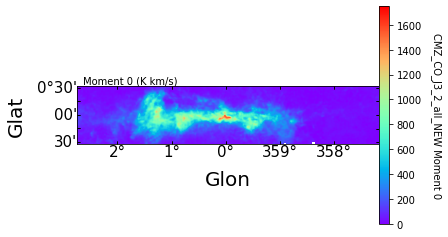

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
0.12457907559358726 Unmatched Noise (K) Abs =  All


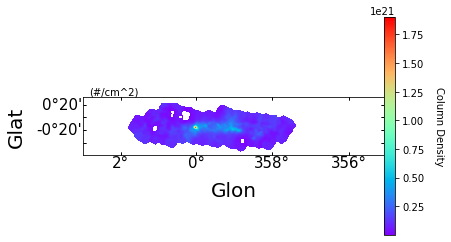

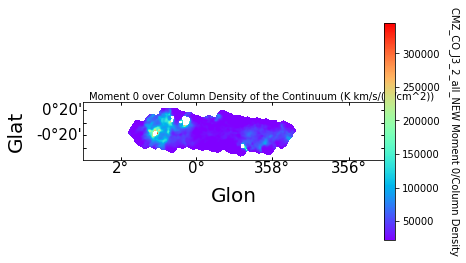

385.4608566059497

6.593930677064913e-08 <class 'float'>
75.66573963576535 arcsec 75.66573963576535 arcsec
28.327249999999516 pix2
5 5 2 0
5 5 2 0 2 2
actiev noise =  0.115
CMZ_CO_J3_2_all_NEW_Cropped_3.0pc_beam__CMZ_CO_J3_2_4.3_start_NMSmoothe_to_2.5Edges200x800pc_2.5_vel_res_0.3_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR_NEW.fits
{'distance': <Quantity 0.008178 Mpc>, 'beam_area_ratioc': <Quantity 28.32725 pix2>, 'wavelength': <Quantity 0.00086696 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 15.13314793 arcsec / pix>, 'arc_per_pix_x': <Quantity 15.13314793 arcsec / pix>, 'beam_major': <Quantity 75.66573964 arcsec>, 'beam_minor': <Quantity 75.66573964 arcsec>, 'beam_area_ratio': <Quantity 28.32725 pix2>, 'spatial_scale': <Quantity 0.00420365 deg>, 'velocity_scale': <Quantity 2.50501098 km / s>, 'vaxis': 0, 'wcsu': WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SIN'  'GLAT-SIN'  'VRAD-F2F'  
CRVAL : 3.0  -0.6  -300300.50840213074  
CRPIX : -61.0  -14.0  1.0  

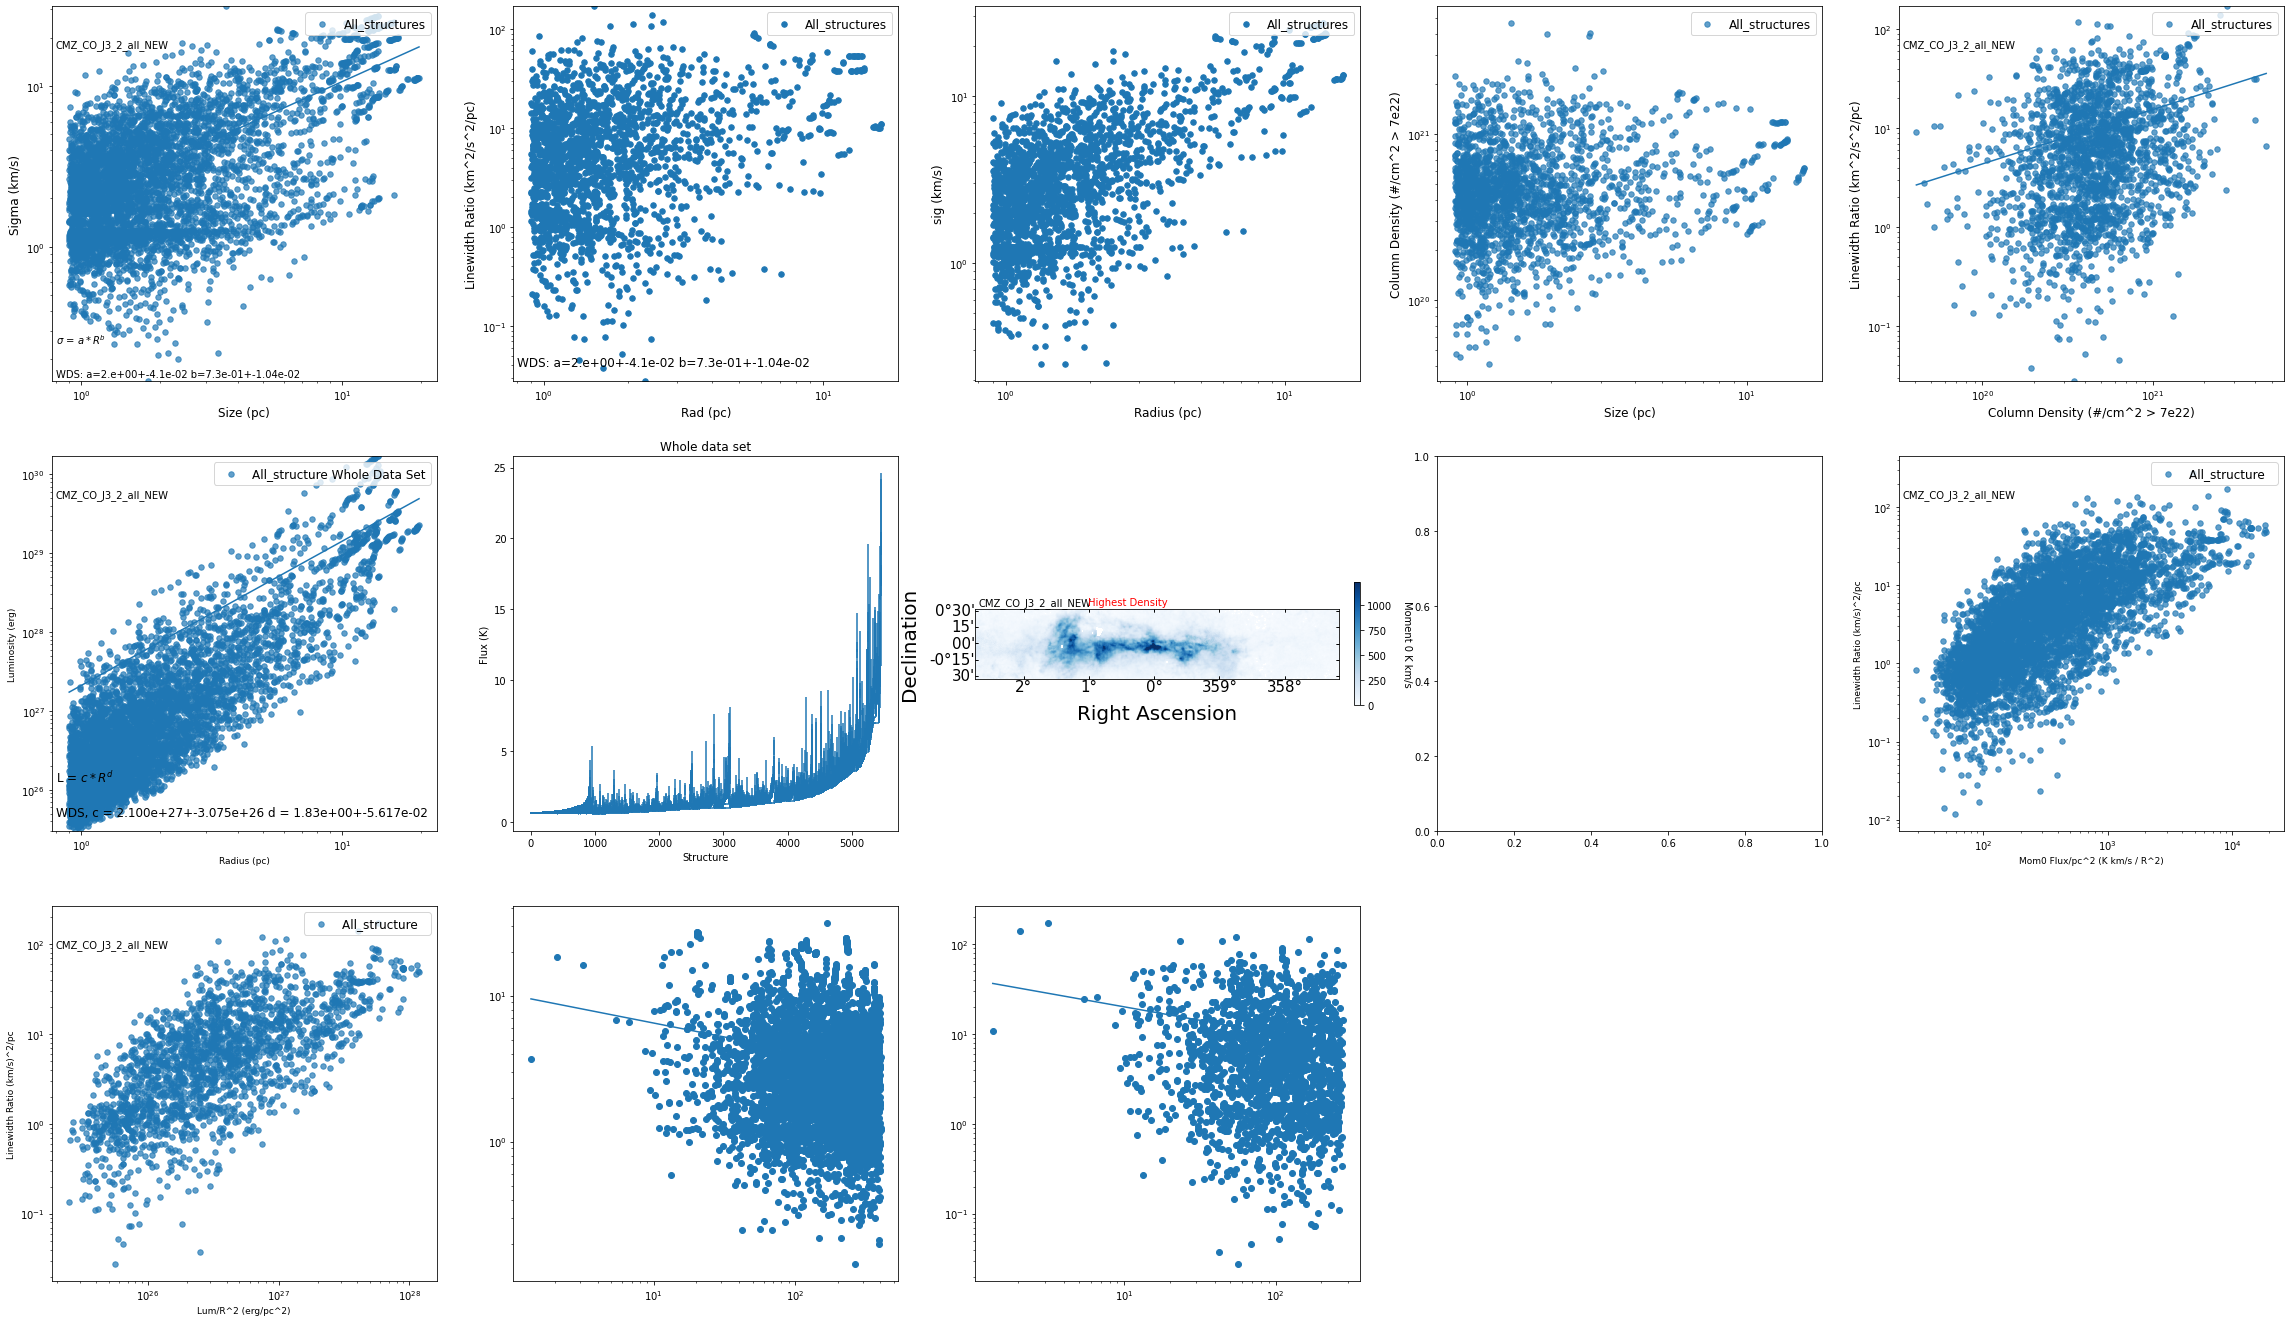

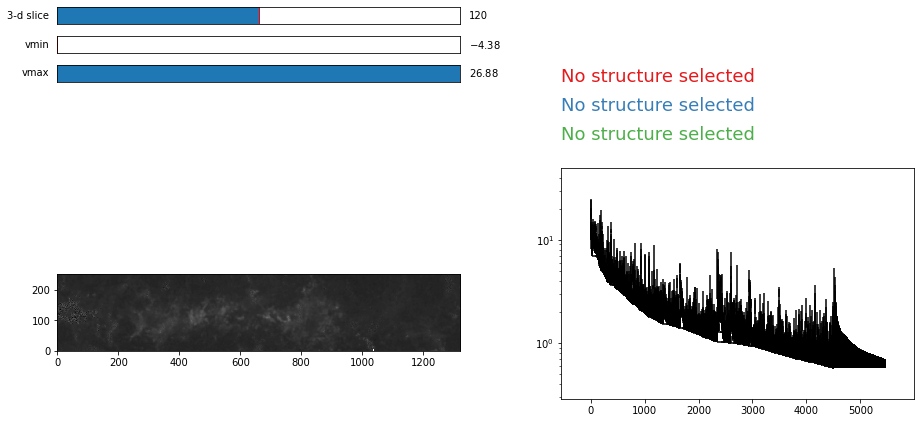

[ 9949. 10070.]


In [3]:
#Krieger

#Beam
Abs_Level = Abs_Levels[0]



if gal =="GC":
    pathCont = '4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'#'CMZ_Continuum_Splice.fits'
else:
    pathCont = 'Continuum_Reproject.fits'





start_num=0
km=0
for kl in range(5,6):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    max_size = Prime_Beam*7   
    if(kl==5):
        Prime_Beam = 3*u.pc#Nico
        km=5
        FOVp=[200,800]
        max_size = 20#pc
        if(Match_to_HCO):
            Prime_Beam = 4.3*u.pc#Nico
            FOVp=[70,360]

    else:
        FOVp=FOV
    print(Prime_Beam)
    
    
    vel_prime = min_vel*((km*iter_factor+1))

    if(km==5):
        vel_prime=2.5
        ovs=5
        if(Match_to_HCO):
            vel_prime=3.3
            ovs=3
    if(kl==5,km==5):
        Trunks=True
    else:
        Trunks=True




    try:
        Names=list(np.load(Name_File+".npy",allow_pickle=True))
        if(iterations!=np.shape(Names)[3]):
            del popasasd
    except Exception as e:

        print(e)
        print("initialized names")
        Names = list(np.empty((20,iterations,iterations,iterations,iterations,iterations,iterations),dtype=object))


    #Continuum image
    scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
    #Put this up here for the column density map
    metadata = {}
    metadata["distance"] = dist_cmz
    arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
    arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
    beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
    beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
    beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
    metadata['beam_area_ratioc']=beam_area_ratioc
    pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
    print(pc_per_pixelc,"MPC per pix")

    #Make subcube


    if(NM):
        Cube_Name_Load = 'Noise_Matched_'+"Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW'+Smoothe_title+'.fits'
    else:
        Cube_Name_Load = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW'+Smoothe_title+'.fits'
    path = Cube_Name_Load

    Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
    Qp.allow_huge_operations=True

    Q = Qp.to(u.K)#Jy to Kelvin

    sc = Q.unmasked_copy()



    scW = sc.wcs[:][:][0]
    dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
    scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
    scF = scn
    datn = dat


    #m=.115

    #print(m,"Presumed Noise (K)")

    #Continuum image
    scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
    #Do the same thing to the continuum image
    scCont.allow_huge_operations=True
    scContW = scCont.reproject(scF.moment0().header)
    #m=.115


    scW = sc.wcs[:][:][0]




    #Do the same thing to the continuum image

    Continuum_Data  =scContW.hdu.data
    scWCS = scF.wcs[:][:][0]

    moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



    ######Moment 0 for both
    ######and cont
    Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


    cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





    rm=moment_0_sub.hdu.data/cSD
    rmU = rm*u.K*u.km/u.s#Just put back in the units
    rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
    print(rmU)

    ######ratio

    bp = np.where(cSD<=.0001*10**22/u.cm**2)
    bp2 = np.where( moment_0_sub.hdu.data < .00022)
    Continuum_Data[bp] = np.nan
    cSD[bp]=np.nan
    rmU[bp]=np.nan
    rmU[bp2]=np.nan

    Non_nan=((datn[0,:,0:int(np.shape(datn)[2]/2)]>0)  | (datn[0,:,0:int(np.shape(datn)[2]/2)]<0 ))

    m = (np.nanstd(datn[0,:,0:int(np.shape(datn)[2]/2)],where= Non_nan)) #Noise K
    mp=m
    if(Abs_Level=="All"):
        pass
    if(Abs_Level=="None"):
        datn[np.where(datn<0)]=np.nan
    if(Abs_Level=="None (m)"):
        datn[np.where(datn<-m)]=np.nan
    if(Abs_Level=="None All Channels"):
        for lmi in range(len(datn)):
            bpP = np.where(datn[lmi]<-m)
            for lmj in range(len(datn)):
                datn[lmj][bpP]=np.nan
    if(Abs_Level=="No Clusters"):

        #IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")

        HWHM_rad,CDs_New,glons_New,glats_New,IDs_New   =    np.genfromtxt("CMZ_Clusters_"+"HWHM"+""),np.genfromtxt("CMZ_Clusters_"+"CD"+""),np.genfromtxt("CMZ_Clusters_"+"Glon"+""),np.genfromtxt("CMZ_Clusters_"+"Glat"+""),np.genfromtxt("CMZ_Clusters_"+"IDs"+"")

        datn=  Mask_Clusters_CMZ(HWHM_rad,scWCS,scF.hdu.header,datn,glons_New,glats_New,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)

    print(m,"Unmatched Noise (K)", "Abs = ",Abs_Level)


    Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
    Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

    print(np.nanmin(rmU))



    header = scF.hdu.header
    print()
    #make metadata for the dendrogram

    try:
        freq = header["RESTFREQ"]*u.Hz#
        metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
        print(1,freq,metadata['wavelength'])
    except:
        freq = header["RESTFRQ"]*u.Hz#
        metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
    metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
    metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
    metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


    metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
    metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
    beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
    metadata['beam_area_ratio']=beam_area_ratio
    metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
    #area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
    #print(area_res,type(area_res))

    print(metadata['beam_minor'],metadata['beam_major'])
    print(beam_area_ratio)
    #metadata["wcs"] = wcs
    metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

    metadata["vaxis"]=0
    metadata["wcsu"]=scF.wcs


    #for k3 in range(start_num):
    k3=2


    beam_req = Min_beam_req*(k3+1)
    if kl==5:
        beam_req=.9/3
    k4=0
    print(kl,km,k3,k4)
    pix_thresh_factor = k4+1
    k6=2
    delt_factor = (3/5+k6/5)

    k7=2
    noise_factor = (3/5+k7/5)
    if(kl==5):
        m=.115
    else:
        m=mp
    print(kl,km,k3,k4,k6,k7)
    print("actiev noise = ",m)
    try:



        Cube_Name_Save = Name+"_Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name_Save+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_'+str(beam_req)+"_beam_size_req_"+str(pix_thresh_factor)+'_times_beam_pixels_'+str(delt_factor)+"_delt_factor_"+str(noise_factor*5)+"_SNR_NEW.fits"



        Names[Num][kl][km][k3][k4][k6][k7] = Cube_Name_Save

        NameS = (Cube_Name_Save+"Sigmas")
        NameR = (Cube_Name_Save+"Radii")
        NameCol = (Cube_Name_Save+"_Column")
        NameLum = (Cube_Name_Save+"_Luminosities")

        NameFlux = (Cube_Name_Save+"Flux_Dense")
        NameRFF = (Cube_Name_Save+"Rad_For_Flux")

        print(Cube_Name_Save)

        #np.save("CMZ_Names_New_All_Kinds",Names)

        np.save(Name_File,Names)




        d = astrodendro.Dendrogram.compute(datn,min_delta=m*delt_factor,min_value=m*5*(noise_factor),min_npix=beam_area_ratio.value*pix_thresh_factor) #The main culprit
        #d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit

        vel,RA,Dec = scF.world[:,0,0]
        Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances,V_err = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata,beam_size=Prime_Beam.value,beam_req=beam_req,Trunks=Trunks,max_size =max_size,edge_cases=Edge_cases )


        ##Analyze dendograms
        pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

        sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


        #Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


        from scipy.optimize import curve_fit
        from scipy.optimize import leastsq

        def func(R,a,b):
            return a*R**(b)
        try:
            popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
        except:
            popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
        try:
            poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
        except:
            poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]



        Rcon = np.concatenate((Rads[0],Rads[1]))


        Scon = np.concatenate((Sigmas[0],Sigmas[1]))
        Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
        print(np.shape(Rcon))

        poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)










        xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

        ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


        LuminCon = np.concatenate((Lumin[0],Lumin[1]))
        ColumnCon= np.concatenate((CD[0],CD[1]))

        MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
        DistancesCon= np.concatenate((Distances[0],Distances[1]))
        print(Distances)

        #Radius Luminosity fit
        #Good pixels are places where the luminosity and therefore column density are above zero
        gp = np.where(LuminCon>0)
        print(np.shape(Rcon),np.shape(LuminCon))
        lgp = LuminCon[gp]
        radgp = Rcon[gp]*10**6

        gp2 = np.where(ColumnCon>0)
        cgp = ColumnCon[gp2]
        rgp=Scon[gp2]**2/Rcon[gp2]/10**6
        dgp=DistancesCon[gp2]
        radgpFORRAT = Rcon[gp2]*10**6
        siggpFORRAT = Scon[gp2]
        lumFORRAT = LuminCon[gp2]
        mom0FORRAT = MOM0FLUXcon[gp2]

        #print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))

        RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

        xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
        ysRL = func(xsRL,RLpopt[0],RLpopt[1])
        #Column density to Size-linewidth
        CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

        Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
        Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

        xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
        xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
        ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
        ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])

        gp3 = np.where(lumFORRAT>0)
        lumFORRAT = lumFORRAT[gp3]
        rgpFORRAT = rgp[gp3]
        mom0FORRAT = mom0FORRAT[gp3]

        xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
        ysCD = func(xsCD,CDpopt[0],CDpopt[1])


        print(poptCon,pcovCon,"Size Linewidth All_structures:")
        print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
        print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


        print(RLpopt,RLpcov,"Radius to Luminosity:")
        print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
        print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



        print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
        print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
        print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



        gp4=np.where(MOM0FLUXcon>0)
        mom0FORFlux=MOM0FLUXcon[gp4]
        radgpFORFlux=Rcon[gp4]*10**6
        rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6


        '''

        '''
        fig = plt.figure(1,figsize=(40,40))


        axAlpha = pylab.subplot(5, 5, 7)
        axBeta = pylab.subplot(5, 5, 8)
        axGamma = pylab.subplot(5, 5, 9)
        axDelta = pylab.subplot(5, 5, 10)




        p1=d.plotter()
        p1.plot_tree(axAlpha)
        axAlpha.set_xlabel("Structure")
        axAlpha.set_ylabel("Flux (K)")
        axAlpha.set_title("Whole data set")



        #Plot contours for the top ten clusters


        #scCropped =scF.moment0().hdu.data
        scCropped =scF.moment0().hdu.data
        scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
        print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
        scCropped[bp]=np.nan
        axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
        #axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
        imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



        ColumnCon= np.concatenate((CD[0],CD[1]))
        SIDScon = np.concatenate((SIDS[0],SIDS[1]))
        nth =0# sorted(CD[0])[len(CD[0])-20]

        G1 = True

        RA = axDelta.coords[0]                                                                  # 
        Dec = axDelta.coords[1]

        RA.set_ticks(size=-3)                                                                                      
        Dec.set_ticks(size=-3) 
        RA.set_ticklabel(exclude_overlapping=True) 
        Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
        pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
        pylab.ylabel('Declination',fontsize=20,labelpad=1)
        axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
        cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
        cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
        cb.ax.tick_params(which = 'major', labelsize = 10)   
        pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
        pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  











        ax2 = pylab.subplot(5, 5, 1)
        ax3 = pylab.subplot(5, 5, 2)
        ax4 = pylab.subplot(5, 5, 3)

        xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


        p = ax2.plot(xs,ysCon)





        st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
        ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

        ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
        ax2.set_yscale('log')
        ax2.set_xscale('log')
        ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
        ax2.set_xlabel("Size (pc)",fontsize=12)
        ax2.set_ylabel("Sigma (km/s)",fontsize=12)
        ax2.legend(prop={'size': 12},loc="upper right")
        ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

        #gp = np.where(FRs>0)







        xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




        ax4.set_yscale('log')
        ax4.set_xscale('log')

        ax4.set_xlabel("Radius (pc)",fontsize=12)
        ax4.set_ylabel("sig (km/s)",fontsize=12)
        ax4.legend(prop={'size': 12},loc="upper right")






        xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

        ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
        ax3.set_yscale('log')
        ax3.set_xscale('log')
        ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
        ax3.set_xlabel("Rad (pc)",fontsize=12)
        ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
        ax3.legend(prop={'size': 12})





        ax5 = pylab.subplot(5, 5, 4)
        ax6 = pylab.subplot(5, 5, 5)
        ax7 = pylab.subplot(5, 5, 6)



        xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
        ax5.set_yscale('log')
        ax5.set_xscale('log')
        ax5.set_xlabel("Size (pc)",fontsize=12)
        ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
        ax5.legend(prop={'size': 12},loc="upper right")




        xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
        pF2 = ax6.plot(xsCD,ysCD)

        ax6.set_yscale('log')
        ax6.set_xscale('log')
        ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
        ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
        ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
        ax6.legend(prop={'size': 12},loc="upper right")
        ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




        xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
        pFLLu2 = ax7.plot(xsRL,ysRL)

        st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
        ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
        ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

        ax7.set_yscale('log')
        ax7.set_xscale('log')
        ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
        ax7.set_xlabel("Radius (pc)",fontsize=9)
        ax7.set_ylabel("Luminosity (erg)",fontsize=9)
        ax7.legend(prop={'size': 12},loc="upper right")
        ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


        axLam = pylab.subplot(5, 5, 11)
        lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
        #Off by factors for area, simply using r^2

        axLam.set_yscale('log')
        axLam.set_xscale('log')
        axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
        axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
        axLam.legend(prop={'size': 12},loc="upper right")
        axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



        axDelta = pylab.subplot(5, 5, 10)






        mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
        #Off by factors for area, simply using r^2

        axDelta.set_yscale('log')
        axDelta.set_xscale('log')
        axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
        axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
        axDelta.legend(prop={'size': 12},loc="upper right")
        axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



        axdis = pylab.subplot(5, 5, 12)
        axdis2 = pylab.subplot(5, 5, 13)
        axdis.scatter(DistancesCon,Scon)
        axdis2.scatter(dgp,rgp)
        axdis.plot(xsDist,ysDist)
        axdis2.plot(xsDist2,ysDist2)
        axdis2.set_yscale('log')
        axdis2.set_xscale('log')
        axdis.set_yscale('log')
        axdis.set_xscale('log')

        pylab.show()









        v1 = d.viewer()
        v1.show()


        #Must use text because np load is broken
        if(Abs_Level=="All"):
            Suffix=''
        if(Abs_Level=="None"):
            Suffix='_NA'
        if(Abs_Level=="No Clusters"):
            Suffix='_No_Clusters'
        if(Abs_Level=="None (m)"):
            Suffix='None_m'
        if(Abs_Level=="None All Channels"):
            Suffix='None_All_Channels'






        np.savetxt(os.path.join(savePath,NameCol+"_Leaves"+Suffix), CD[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameCol+"_Branches"+Suffix), CD[1],fmt='%s')



        np.savetxt(os.path.join(savePath,NameLum+"_Leaves"+Suffix), Lumin[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameLum+"_Branches"+Suffix), Lumin[1],fmt='%s')





        np.savetxt(os.path.join(savePath,NameS+"_Leaves"+Suffix), Sigmas[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameS+"_Branches"+Suffix), Sigmas[1],fmt='%s')



        np.savetxt(os.path.join(savePath,NameR+"_Leaves"+Suffix), Rads[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameR+"_Branches"+Suffix), Rads[1],fmt='%s')


        np.savetxt(os.path.join(savePath,NameFlux+"_Leaves"+Suffix), MOM0FLUX[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameFlux+"_Branches"+Suffix), MOM0FLUX[1],fmt='%s')



        np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Leaves"+Suffix), Distances[0],fmt='%s')
        np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Branches"+Suffix), Distances[1],fmt='%s')






        np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Leaves"+Suffix), V_err[0],fmt='%s')
        np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Branches"+Suffix), V_err[1],fmt='%s')

        SIDS=np.concatenate((SIDS[0],SIDS[1]))

        print(SIDS[len(SIDS)-3:len(SIDS)-1])

        
        
        import datetime
        now = str(datetime.datetime.now())
        string=now+ " "+ "Nico's method, common Gauss Smoothing (No Trunks,  min size=.9pc, delt = 1*m, m=.115K, SNR=5, max_size=21pc, G_width = sqrt(2.5^2-1),NM=true )"
        ax2.annotate(s=string,fontsize=18,xy=(0.01,1.0),xycoords="axes fraction")
    except Exception as e:
        print(e)
        print(kl,km,k3,k4)
        print("Failed")
        print("-"*60)
        traceback.print_exc(file=sys.stdout)

        if(Abs_Level=="All"):
            Suffix=''
        if(Abs_Level=="None"):
            Suffix='_NA'
        if(Abs_Level=="No Clusters"):
            Suffix='_No_Clusters'
        if(Abs_Level=="None (m)"):
            Suffix='None_m'
        if(Abs_Level=="None All Channels"):
            Suffix='None_All_Channels'
        nans = [[np.nan,np.nan],[np.nan,np.nan]]



        np.savetxt(os.path.join(savePath,NameCol+"_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameCol+"_Branches"+Suffix), nans[1],fmt='%s')



        np.savetxt(os.path.join(savePath,NameLum+"_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameLum+"_Branches"+Suffix), nans[1],fmt='%s')





        np.savetxt(os.path.join(savePath,NameS+"_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameS+"_Branches"+Suffix), nans[1],fmt='%s')



        np.savetxt(os.path.join(savePath,NameR+"_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameR+"_Branches"+Suffix), nans[1],fmt='%s')


        np.savetxt(os.path.join(savePath,NameFlux+"_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameFlux+"_Branches"+Suffix), nans[1],fmt='%s')



        np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Branches"+Suffix), nans[1],fmt='%s')






        np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Branches"+Suffix), nans[1],fmt='%s')



4.3 pc
8.600000000000026e-07 MPC per pix


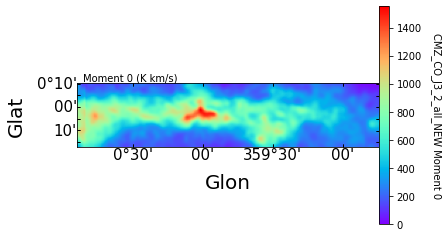

[[  27117.84625002   29239.40882261   33095.41281735 ...              nan
               nan              nan]
 [  29912.73854966   32357.59311644   36379.63647994 ...              nan
               nan              nan]
 [  33382.17326888   36044.29785016   40258.56951612 ...              nan
               nan              nan]
 ...
 [ 130534.33587646  291035.0458504  -319109.66105315 ...              nan
               nan              nan]
 [ 131793.16187902  264387.82335567 -289084.70154623 ...              nan
               nan              nan]
 [ 139078.8628408   276010.94933196 -270875.50998111 ...              nan
               nan              nan]]
0.028853039830151445 Unmatched Noise (K) Abs =  All


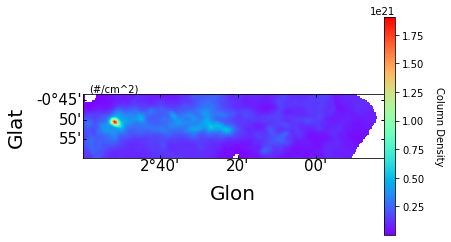

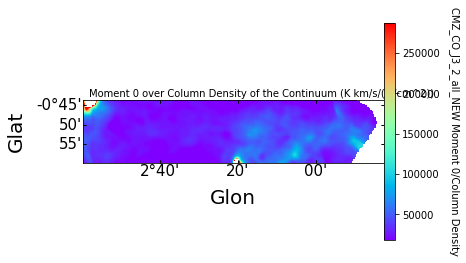

4862.351685585511

108.45422681126364 arcsec 108.45422681126364 arcsec
10.197809999999931 pix2
5 5 2 0
5 5 2 0 2 2
actiev noise =  0.115
CMZ_CO_J3_2_all_NEW_Cropped_4.3pc_beam__CMZ_CO_J3_2_4.3_startSmoothe_to_3.3Edges70x360pc_3.3_vel_res_0.26666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR_NEW.fits
{'distance': <Quantity 0.008178 Mpc>, 'beam_area_ratioc': <Quantity 28.32725 pix2>, 'wavelength': <Quantity 0.00086696 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 36.15140894 arcsec / pix>, 'arc_per_pix_x': <Quantity 36.15140894 arcsec / pix>, 'beam_major': <Quantity 108.45422681 arcsec>, 'beam_minor': <Quantity 108.45422681 arcsec>, 'beam_area_ratio': <Quantity 10.19781 pix2>, 'spatial_scale': <Quantity 0.01004206 deg>, 'velocity_scale': <Quantity 3.3 km / s>, 'vaxis': 0, 'wcsu': WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SIN'  'GLAT-SIN'  'VRAD'  
CRVAL : 3.0  -0.6  -299999.99999999424  
CRPIX : -209.0  -31.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  

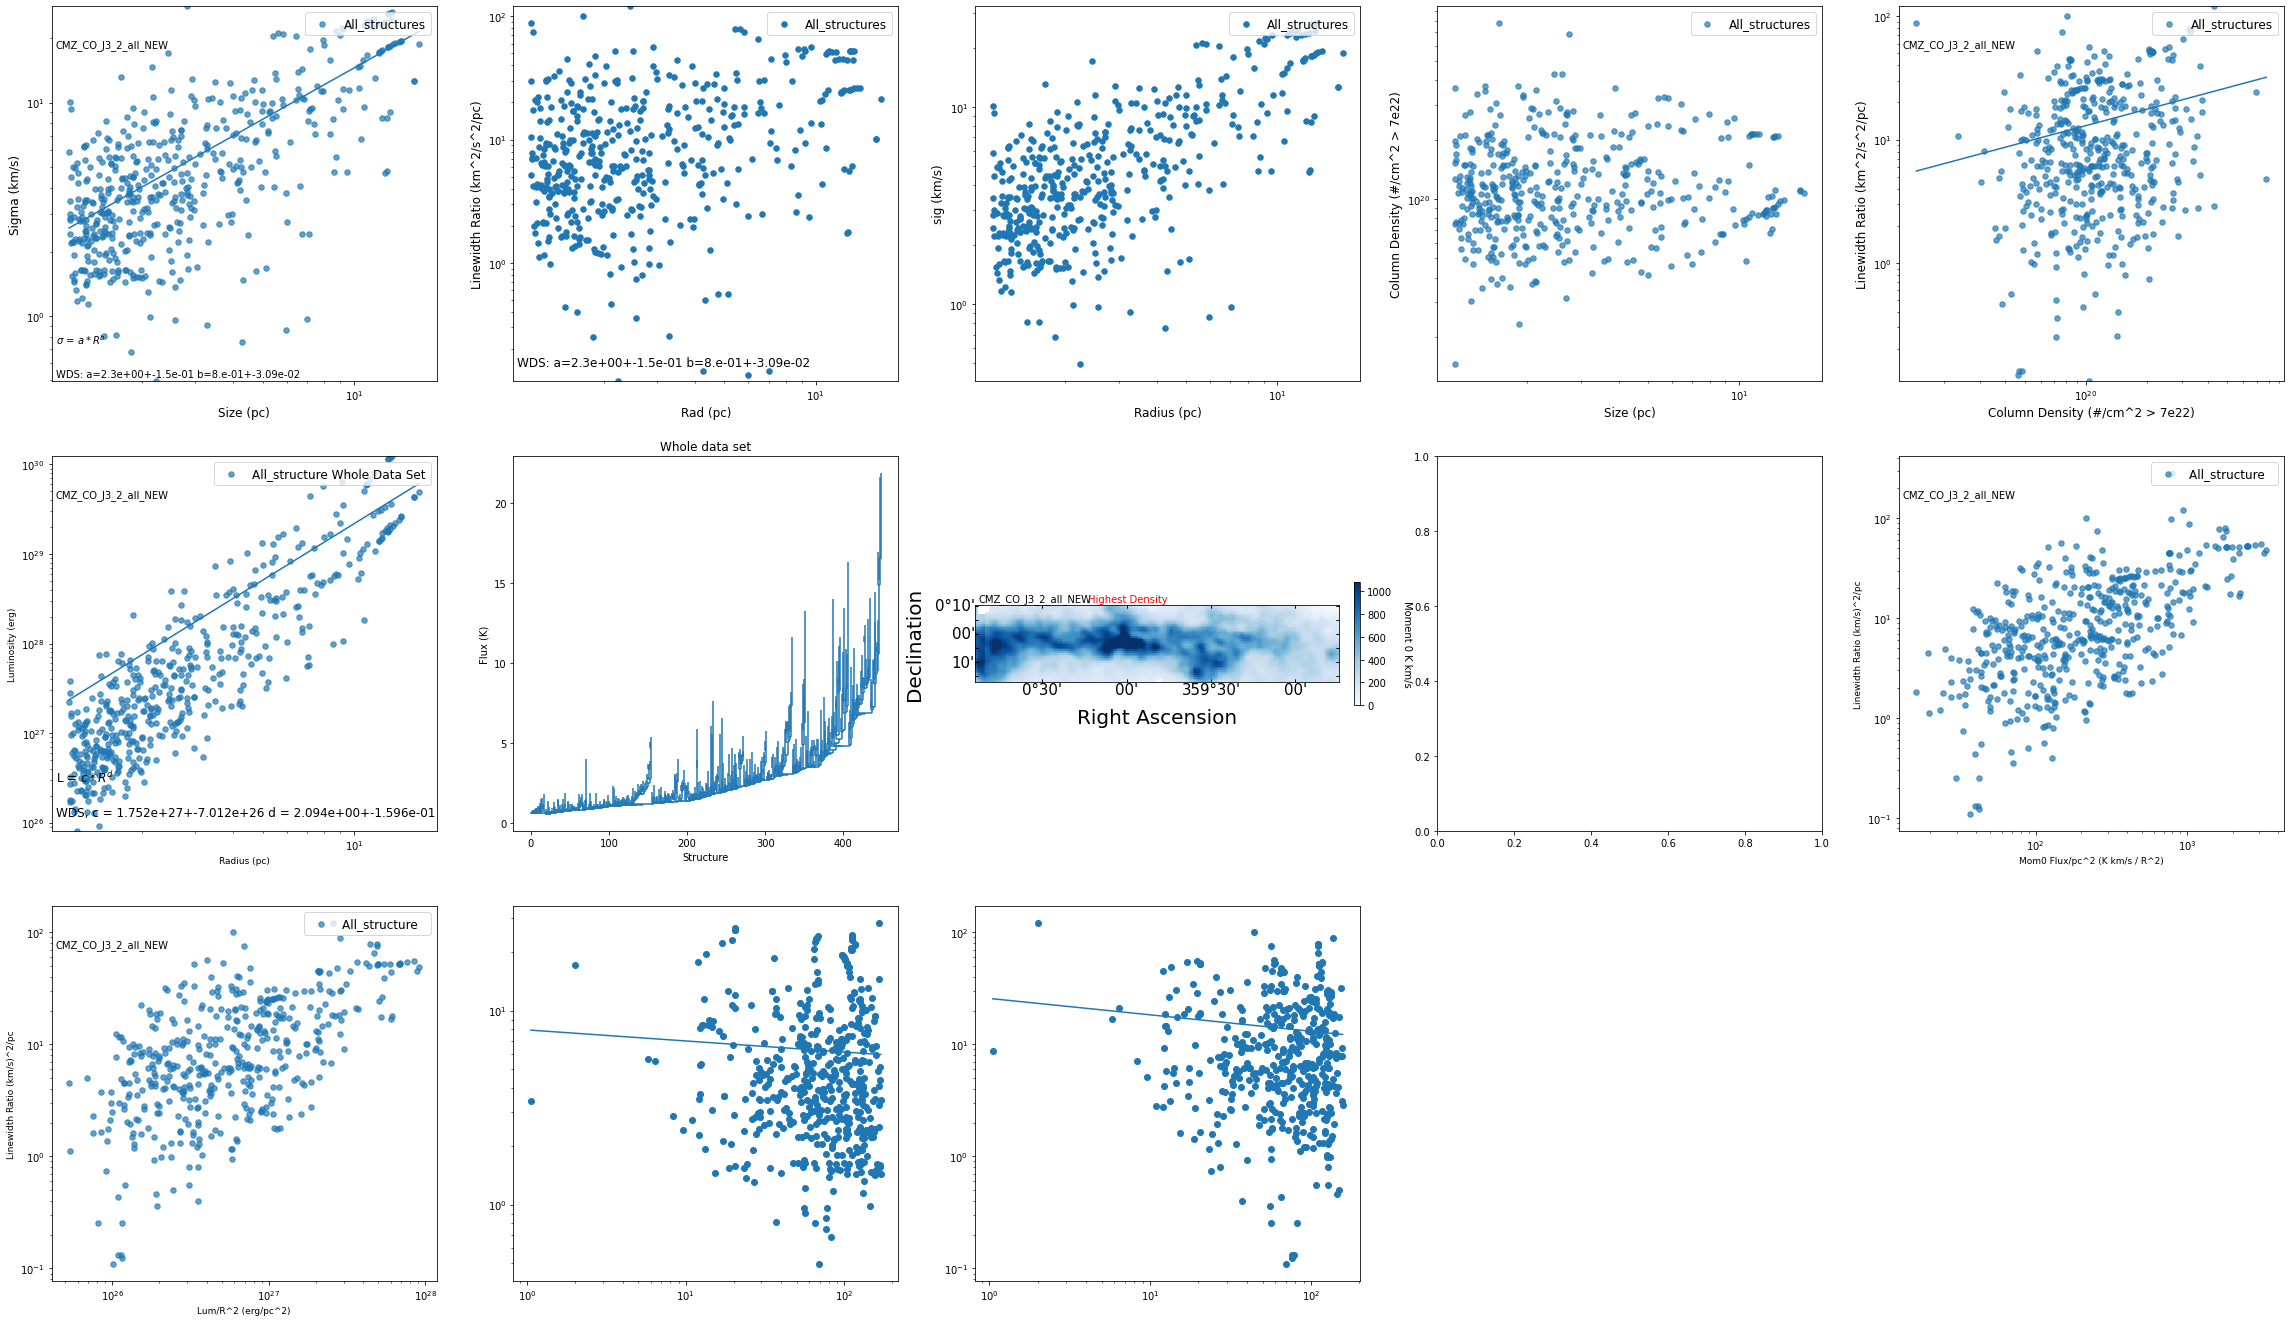

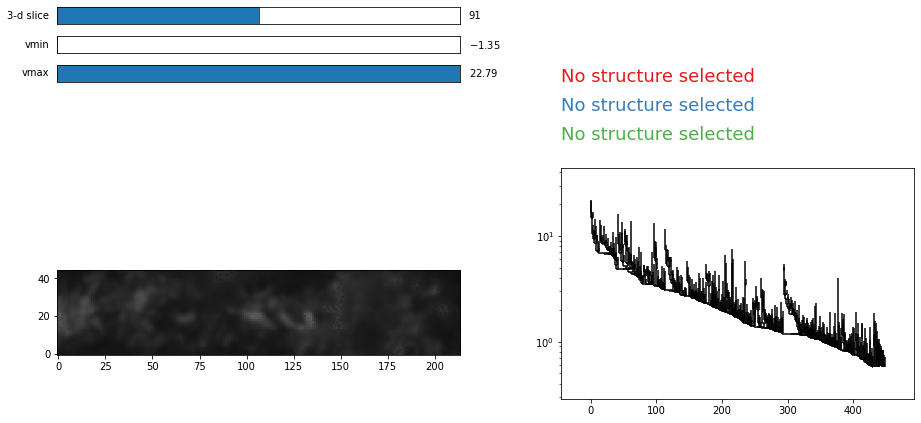

[878. 851.]


In [9]:
#not Krieger

#Beam
Abs_Level = Abs_Levels[0]



if gal =="GC":
    pathCont = '4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'#'CMZ_Continuum_Splice.fits'
else:
    pathCont = 'Continuum_Reproject.fits'





start_num=0
km=0
for kl in range(5,6):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    max_size = (Prime_Beam*7).value 
    if(kl==5):
        Prime_Beam = 3*u.pc#Nico
        km=5
        FOVp=[200,800]
        max_size = 20#pc
        if(Match_to_HCO):
            Prime_Beam = 4.3*u.pc#Nico
            FOVp=[70,360]

    else:
        FOVp=FOV
    print(Prime_Beam)
    
    
    vel_prime = min_vel*((km*iter_factor+1))

    if(km==5):
        vel_prime=2.5
        ovs=5
        if(Match_to_HCO):
            vel_prime=3.3
            ovs=3
    if(kl==5,km==5):
        Trunks=True
    else:
        Trunks=True




    try:
        Names=list(np.load(Name_File+".npy",allow_pickle=True))
        if(iterations!=np.shape(Names)[3]):
            del popasasd
    except Exception as e:

        print(e)
        print("initialized names")
        Names = list(np.empty((20,iterations,iterations,iterations,iterations,iterations,iterations),dtype=object))


    #Continuum image
    scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
    #Put this up here for the column density map
    metadata = {}
    metadata["distance"] = dist_cmz
    arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
    arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
    beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
    beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
    beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
    metadata['beam_area_ratioc']=beam_area_ratioc
    pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
    print(pc_per_pixelc,"MPC per pix")

    #Make subcube


    if(NM):
        Cube_Name_Load = 'Noise_Matched_'+"Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW'+Smoothe_title+'.fits'
    else:
        Cube_Name_Load = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW'+Smoothe_title+'.fits'
    path = Cube_Name_Load

    Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
    Qp.allow_huge_operations=True

    Q = Qp.to(u.K)#Jy to Kelvin

    sc = Q.unmasked_copy()



    scW = sc.wcs[:][:][0]
    dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
    scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
    scF = scn
    datn = dat


    #m=.115

    #print(m,"Presumed Noise (K)")

    #Continuum image
    scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
    #Do the same thing to the continuum image
    scCont.allow_huge_operations=True
    scContW = scCont.reproject(scF.moment0().header)
    #m=.115


    scW = sc.wcs[:][:][0]




    #Do the same thing to the continuum image

    Continuum_Data  =scContW.hdu.data
    scWCS = scF.wcs[:][:][0]

    moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



    ######Moment 0 for both
    ######and cont
    Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


    cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





    rm=moment_0_sub.hdu.data/cSD
    rmU = rm*u.K*u.km/u.s#Just put back in the units
    rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
    print(rmU)

    ######ratio

    bp = np.where(cSD<=.0001*10**22/u.cm**2)
    bp2 = np.where( moment_0_sub.hdu.data < .00022)
    Continuum_Data[bp] = np.nan
    cSD[bp]=np.nan
    rmU[bp]=np.nan
    rmU[bp2]=np.nan

    Non_nan=((datn[0,:,0:int(np.shape(datn)[2]/2)]>0)  | (datn[0,:,0:int(np.shape(datn)[2]/2)]<0 ))

    m = (np.nanstd(datn[0,:,0:int(np.shape(datn)[2]/2)],where= Non_nan)) #Noise K
    mp=m
    if(Abs_Level=="All"):
        pass
    if(Abs_Level=="None"):
        datn[np.where(datn<0)]=np.nan
    if(Abs_Level=="None (m)"):
        datn[np.where(datn<-m)]=np.nan
    if(Abs_Level=="None All Channels"):
        for lmi in range(len(datn)):
            bpP = np.where(datn[lmi]<-m)
            for lmj in range(len(datn)):
                datn[lmj][bpP]=np.nan
    if(Abs_Level=="No Clusters"):

        #IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")

        HWHM_rad,CDs_New,glons_New,glats_New,IDs_New   =    np.genfromtxt("CMZ_Clusters_"+"HWHM"+""),np.genfromtxt("CMZ_Clusters_"+"CD"+""),np.genfromtxt("CMZ_Clusters_"+"Glon"+""),np.genfromtxt("CMZ_Clusters_"+"Glat"+""),np.genfromtxt("CMZ_Clusters_"+"IDs"+"")

        datn=  Mask_Clusters_CMZ(HWHM_rad,scWCS,scF.hdu.header,datn,glons_New,glats_New,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)

    print(m,"Unmatched Noise (K)", "Abs = ",Abs_Level)


    Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
    Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

    print(np.nanmin(rmU))



    header = scF.hdu.header
    print()
    #make metadata for the dendrogram

    try:
        freq = header["RESTFREQ"]*u.Hz#
        metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
        print(1,freq,metadata['wavelength'])
    except:
        freq = header["RESTFRQ"]*u.Hz#
        metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
    metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
    metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
    metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


    metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
    metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
    beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
    metadata['beam_area_ratio']=beam_area_ratio
    metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
    #area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
    #print(area_res,type(area_res))

    print(metadata['beam_minor'],metadata['beam_major'])
    print(beam_area_ratio)
    #metadata["wcs"] = wcs
    metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

    metadata["vaxis"]=0
    metadata["wcsu"]=scF.wcs


    #for k3 in range(start_num):
    k3=2


    beam_req = Min_beam_req*(k3+1)
    if kl==5:
        beam_req=.8/3
    k4=0
    print(kl,km,k3,k4)
    pix_thresh_factor = k4+1
    k6=2
    delt_factor = (3/5+k6/5)

    k7=2
    noise_factor = (3/5+k7/5)
    if(kl==5):
        m=.115
    else:
        m=mp
    print(kl,km,k3,k4,k6,k7)
    print("actiev noise = ",m)
    try:



        Cube_Name_Save = Name+"_Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name_Save+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_'+str(beam_req)+"_beam_size_req_"+str(pix_thresh_factor)+'_times_beam_pixels_'+str(delt_factor)+"_delt_factor_"+str(noise_factor*5)+"_SNR_NEW.fits"



        Names[Num][kl][km][k3][k4][k6][k7] = Cube_Name_Save

        NameS = (Cube_Name_Save+"Sigmas")
        NameR = (Cube_Name_Save+"Radii")
        NameCol = (Cube_Name_Save+"_Column")
        NameLum = (Cube_Name_Save+"_Luminosities")

        NameFlux = (Cube_Name_Save+"Flux_Dense")
        NameRFF = (Cube_Name_Save+"Rad_For_Flux")

        print(Cube_Name_Save)

        #np.save("CMZ_Names_New_All_Kinds",Names)

        np.save(Name_File,Names)




        d = astrodendro.Dendrogram.compute(datn,min_delta=m*delt_factor,min_value=m*5*(noise_factor),min_npix=beam_area_ratio.value*pix_thresh_factor) #The main culprit
        #d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit

        vel,RA,Dec = scF.world[:,0,0]
        Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX,Distances,V_err = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata,beam_size=Prime_Beam.value,beam_req=beam_req,Trunks=Trunks,max_size =max_size,edge_cases=Edge_cases )


        ##Analyze dendograms
        pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

        sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


        #Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


        from scipy.optimize import curve_fit
        from scipy.optimize import leastsq

        def func(R,a,b):
            return a*R**(b)
        try:
            popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
        except:
            popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
        try:
            poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
        except:
            poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]



        Rcon = np.concatenate((Rads[0],Rads[1]))


        Scon = np.concatenate((Sigmas[0],Sigmas[1]))
        Scon2 = np.concatenate((Sigmas[2],Sigmas[3]))
        print(np.shape(Rcon))

        poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)










        xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)

        ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])


        LuminCon = np.concatenate((Lumin[0],Lumin[1]))
        ColumnCon= np.concatenate((CD[0],CD[1]))

        MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
        DistancesCon= np.concatenate((Distances[0],Distances[1]))
        print(Distances)

        #Radius Luminosity fit
        #Good pixels are places where the luminosity and therefore column density are above zero
        gp = np.where(LuminCon>0)
        print(np.shape(Rcon),np.shape(LuminCon))
        lgp = LuminCon[gp]
        radgp = Rcon[gp]*10**6

        gp2 = np.where(ColumnCon>0)
        cgp = ColumnCon[gp2]
        rgp=Scon[gp2]**2/Rcon[gp2]/10**6
        dgp=DistancesCon[gp2]
        radgpFORRAT = Rcon[gp2]*10**6
        siggpFORRAT = Scon[gp2]
        lumFORRAT = LuminCon[gp2]
        mom0FORRAT = MOM0FLUXcon[gp2]

        #print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))

        RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

        xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
        ysRL = func(xsRL,RLpopt[0],RLpopt[1])
        #Column density to Size-linewidth
        CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)

        Dist_popt,Dist_pcov = curve_fit(func, np.array(DistancesCon,dtype='float64') ,np.array(Scon,dtype='float64'),maxfev=9999099,ftol = 10**-10)
        Dist_popt2,Dist_pcov2 = curve_fit(func, np.array(dgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,ftol = 10**-10)

        xsDist=np.linspace(np.nanmin(DistancesCon),np.nanmax(DistancesCon),50)
        xsDist2=np.linspace(np.nanmin(dgp),np.nanmax(dgp),50)
        ysDist=func(xsDist,Dist_popt[0],Dist_popt[1])
        ysDist2=func(xsDist2,Dist_popt2[0],Dist_popt2[1])

        gp3 = np.where(lumFORRAT>0)
        lumFORRAT = lumFORRAT[gp3]
        rgpFORRAT = rgp[gp3]
        mom0FORRAT = mom0FORRAT[gp3]

        xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
        ysCD = func(xsCD,CDpopt[0],CDpopt[1])


        print(poptCon,pcovCon,"Size Linewidth All_structures:")
        print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
        print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))


        print(RLpopt,RLpcov,"Radius to Luminosity:")
        print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
        print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))



        print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
        print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
        print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



        gp4=np.where(MOM0FLUXcon>0)
        mom0FORFlux=MOM0FLUXcon[gp4]
        radgpFORFlux=Rcon[gp4]*10**6
        rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6


        '''

        '''
        fig = plt.figure(1,figsize=(40,40))


        axAlpha = pylab.subplot(5, 5, 7)
        axBeta = pylab.subplot(5, 5, 8)
        axGamma = pylab.subplot(5, 5, 9)
        axDelta = pylab.subplot(5, 5, 10)




        p1=d.plotter()
        p1.plot_tree(axAlpha)
        axAlpha.set_xlabel("Structure")
        axAlpha.set_ylabel("Flux (K)")
        axAlpha.set_title("Whole data set")



        #Plot contours for the top ten clusters


        #scCropped =scF.moment0().hdu.data
        scCropped =scF.moment0().hdu.data
        scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
        print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
        scCropped[bp]=np.nan
        axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
        #axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
        imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



        ColumnCon= np.concatenate((CD[0],CD[1]))
        SIDScon = np.concatenate((SIDS[0],SIDS[1]))
        nth =0# sorted(CD[0])[len(CD[0])-20]

        G1 = True

        RA = axDelta.coords[0]                                                                  # 
        Dec = axDelta.coords[1]

        RA.set_ticks(size=-3)                                                                                      
        Dec.set_ticks(size=-3) 
        RA.set_ticklabel(exclude_overlapping=True) 
        Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
        pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
        pylab.ylabel('Declination',fontsize=20,labelpad=1)
        axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
        cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
        cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
        cb.ax.tick_params(which = 'major', labelsize = 10)   
        pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
        pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  











        ax2 = pylab.subplot(5, 5, 1)
        ax3 = pylab.subplot(5, 5, 2)
        ax4 = pylab.subplot(5, 5, 3)

        xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)


        p = ax2.plot(xs,ysCon)





        st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
        ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

        ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
        ax2.set_yscale('log')
        ax2.set_xscale('log')
        ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
        ax2.set_xlabel("Size (pc)",fontsize=12)
        ax2.set_ylabel("Sigma (km/s)",fontsize=12)
        ax2.legend(prop={'size': 12},loc="upper right")
        ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

        #gp = np.where(FRs>0)







        xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




        ax4.set_yscale('log')
        ax4.set_xscale('log')

        ax4.set_xlabel("Radius (pc)",fontsize=12)
        ax4.set_ylabel("sig (km/s)",fontsize=12)
        ax4.legend(prop={'size': 12},loc="upper right")






        xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)

        ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
        ax3.set_yscale('log')
        ax3.set_xscale('log')
        ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
        ax3.set_xlabel("Rad (pc)",fontsize=12)
        ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
        ax3.legend(prop={'size': 12})





        ax5 = pylab.subplot(5, 5, 4)
        ax6 = pylab.subplot(5, 5, 5)
        ax7 = pylab.subplot(5, 5, 6)



        xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
        ax5.set_yscale('log')
        ax5.set_xscale('log')
        ax5.set_xlabel("Size (pc)",fontsize=12)
        ax5.set_ylabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
        ax5.legend(prop={'size': 12},loc="upper right")




        xspF2 = ax6.scatter(cgp,rgp,label="All_structures",s=30,alpha=.7)
        pF2 = ax6.plot(xsCD,ysCD)

        ax6.set_yscale('log')
        ax6.set_xscale('log')
        ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
        ax6.set_xlabel("Column Density (#/cm^2 > 7e22)",fontsize=12)
        ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
        ax6.legend(prop={'size': 12},loc="upper right")
        ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




        xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
        pFLLu2 = ax7.plot(xsRL,ysRL)

        st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
        ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
        ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

        ax7.set_yscale('log')
        ax7.set_xscale('log')
        ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
        ax7.set_xlabel("Radius (pc)",fontsize=9)
        ax7.set_ylabel("Luminosity (erg)",fontsize=9)
        ax7.legend(prop={'size': 12},loc="upper right")
        ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


        axLam = pylab.subplot(5, 5, 11)
        lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
        #Off by factors for area, simply using r^2

        axLam.set_yscale('log')
        axLam.set_xscale('log')
        axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
        axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
        axLam.legend(prop={'size': 12},loc="upper right")
        axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



        axDelta = pylab.subplot(5, 5, 10)






        mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
        #Off by factors for area, simply using r^2

        axDelta.set_yscale('log')
        axDelta.set_xscale('log')
        axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
        axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
        axDelta.legend(prop={'size': 12},loc="upper right")
        axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



        axdis = pylab.subplot(5, 5, 12)
        axdis2 = pylab.subplot(5, 5, 13)
        axdis.scatter(DistancesCon,Scon)
        axdis2.scatter(dgp,rgp)
        axdis.plot(xsDist,ysDist)
        axdis2.plot(xsDist2,ysDist2)
        axdis2.set_yscale('log')
        axdis2.set_xscale('log')
        axdis.set_yscale('log')
        axdis.set_xscale('log')

        pylab.show()









        v1 = d.viewer()
        v1.show()


        #Must use text because np load is broken
        if(Abs_Level=="All"):
            Suffix=''
        if(Abs_Level=="None"):
            Suffix='_NA'
        if(Abs_Level=="No Clusters"):
            Suffix='_No_Clusters'
        if(Abs_Level=="None (m)"):
            Suffix='None_m'
        if(Abs_Level=="None All Channels"):
            Suffix='None_All_Channels'






        np.savetxt(os.path.join(savePath,NameCol+"_Leaves"+Suffix), CD[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameCol+"_Branches"+Suffix), CD[1],fmt='%s')



        np.savetxt(os.path.join(savePath,NameLum+"_Leaves"+Suffix), Lumin[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameLum+"_Branches"+Suffix), Lumin[1],fmt='%s')





        np.savetxt(os.path.join(savePath,NameS+"_Leaves"+Suffix), Sigmas[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameS+"_Branches"+Suffix), Sigmas[1],fmt='%s')



        np.savetxt(os.path.join(savePath,NameR+"_Leaves"+Suffix), Rads[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameR+"_Branches"+Suffix), Rads[1],fmt='%s')


        np.savetxt(os.path.join(savePath,NameFlux+"_Leaves"+Suffix), MOM0FLUX[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameFlux+"_Branches"+Suffix), MOM0FLUX[1],fmt='%s')



        np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Leaves"+Suffix), Distances[0],fmt='%s')
        np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Branches"+Suffix), Distances[1],fmt='%s')






        np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Leaves"+Suffix), V_err[0],fmt='%s')
        np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Branches"+Suffix), V_err[1],fmt='%s')

        SIDS=np.concatenate((SIDS[0],SIDS[1]))

        print(SIDS[len(SIDS)-3:len(SIDS)-1])

        
        
        import datetime
        now = str(datetime.datetime.now())
        string=now+ " "+ "Nico's method, common Gauss Smoothing (No Trunks,  min size=.9pc, delt = 1*m, m=.115K, SNR=5, max_size=21pc, G_width = sqrt(2.5^2-1),NM=true )"
        ax2.annotate(s=string,fontsize=18,xy=(0.01,1.0),xycoords="axes fraction")
    except Exception as e:
        print(e)
        print(kl,km,k3,k4)
        print("Failed")
        print("-"*60)
        traceback.print_exc(file=sys.stdout)

        if(Abs_Level=="All"):
            Suffix=''
        if(Abs_Level=="None"):
            Suffix='_NA'
        if(Abs_Level=="No Clusters"):
            Suffix='_No_Clusters'
        if(Abs_Level=="None (m)"):
            Suffix='None_m'
        if(Abs_Level=="None All Channels"):
            Suffix='None_All_Channels'
        nans = [[np.nan,np.nan],[np.nan,np.nan]]



        np.savetxt(os.path.join(savePath,NameCol+"_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameCol+"_Branches"+Suffix), nans[1],fmt='%s')



        np.savetxt(os.path.join(savePath,NameLum+"_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameLum+"_Branches"+Suffix), nans[1],fmt='%s')





        np.savetxt(os.path.join(savePath,NameS+"_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameS+"_Branches"+Suffix), nans[1],fmt='%s')



        np.savetxt(os.path.join(savePath,NameR+"_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameR+"_Branches"+Suffix), nans[1],fmt='%s')


        np.savetxt(os.path.join(savePath,NameFlux+"_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,NameFlux+"_Branches"+Suffix), nans[1],fmt='%s')



        np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,Cube_Name_Save+"Distances_Branches"+Suffix), nans[1],fmt='%s')






        np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Leaves"+Suffix), nans[0],fmt='%s')
        np.savetxt(os.path.join(savePath,Cube_Name_Save+"V_err_Branches"+Suffix), nans[1],fmt='%s')



3.0 pc
[None None None None None None]
8.600000000000026e-07 MPC per pix


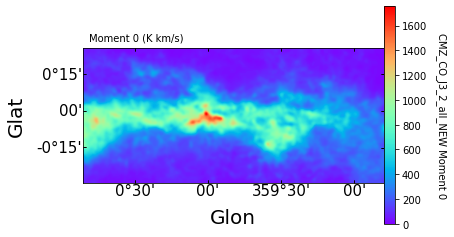

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
0.033921403946218766 Unmatched Noise (K) Abs =  All


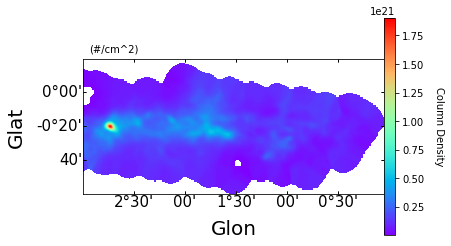

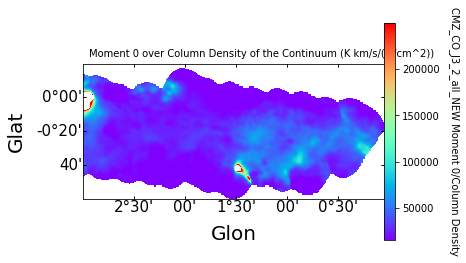

1968.169802986873

6.593930677064913e-08 <class 'float'>
75.66573963576535 arcsec 75.66573963576535 arcsec
28.327249999999516 pix2
5 5 2 0
5 5 2 0 2 2
CMZ_CO_J3_2_all_NEW_Cropped_3.0pc_beam__CMZ_CO_J3_2_4.3_start140x800pc_2.5_vel_res_0.26666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR_NEW.fits
[None None
 'CMZ_CO_J3_2_all_NEW_Cropped_3.0pc_beam__CMZ_CO_J3_2_4.3_start140x800pc_2.5_vel_res_0.26666666666666666_beam_size_req_1_times_beam_pixels_1.0_delt_factor_5.0_SNR_NEW.fits'
 None None None]


In [12]:
#FIX NAMES
Abs_Level = Abs_Levels[0]



if gal =="GC":
    pathCont = '4.3pc_beam_CMZ_850um_Cont_140x800pc.fits'#'CMZ_Continuum_Splice.fits'
else:
    pathCont = 'Continuum_Reproject.fits'



Trunks=True

start_num=0
km=0
for kl in range(5,6):
      
    Prime_Beam = Min_res*((kl*iter_factor+1))#
    
    if(kl==5):
        Prime_Beam = 3*u.pc#Nico
        km=5
    print(Prime_Beam)
    vel_prime = min_vel*((km*iter_factor+1))

    if(km==5):
        vel_prime=2.5
    if(kl==5,km==5):
        Trunks=True
    else:
        Trunks=True




    try:
        Names=list(np.load(Name_File+".npy",allow_pickle=True))
        if(iterations!=np.shape(Names)[3]):
            del popasasd
    except Exception as e:

        print(e)
        print("initialized names")
        Names = list(np.empty((20,iterations,iterations,iterations,iterations,iterations,iterations),dtype=object))

    print(Names[Num][kl][km][k3][k4][k6])
    #Continuum image
    scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
    #Put this up here for the column density map
    metadata = {}
    metadata["distance"] = dist_cmz
    arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
    arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
    beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
    beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
    beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
    metadata['beam_area_ratioc']=beam_area_ratioc
    pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
    print(pc_per_pixelc,"MPC per pix")

    #Make subcube


    if(NM):
        Cube_Name_Load = 'Noise_Matched_'+"Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW.fits'
    else:
        Cube_Name_Load = "Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_NEW.fits'
    path = Cube_Name_Load

    Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
    Qp.allow_huge_operations=True

    Q = Qp.to(u.K)#Jy to Kelvin

    sc = Q.unmasked_copy()



    scW = sc.wcs[:][:][0]
    dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
    scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
    scF = scn
    datn = dat


    #m=.115

    #print(m,"Presumed Noise (K)")

    #Continuum image
    scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
    #Do the same thing to the continuum image
    scCont.allow_huge_operations=True
    scContW = scCont.reproject(scF.moment0().header)
    #m=.115


    scW = sc.wcs[:][:][0]




    #Do the same thing to the continuum image

    Continuum_Data  =scContW.hdu.data
    scWCS = scF.wcs[:][:][0]

    moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



    ######Moment 0 for both
    ######and cont
    Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


    cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number





    rm=moment_0_sub.hdu.data/cSD
    rmU = rm*u.K*u.km/u.s#Just put back in the units
    rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
    print(rmU)

    ######ratio

    bp = np.where(cSD<=.0001*10**22/u.cm**2)
    bp2 = np.where( moment_0_sub.hdu.data < .00022)
    Continuum_Data[bp] = np.nan
    cSD[bp]=np.nan
    rmU[bp]=np.nan
    rmU[bp2]=np.nan

    Non_nan=((datn[0,:,0:int(np.shape(datn)[2]/2)]>0)  | (datn[0,:,0:int(np.shape(datn)[2]/2)]<0 ))

    m = (np.nanstd(datn[0,:,0:int(np.shape(datn)[2]/2)],where= Non_nan)) #Noise K
    mp=m
    if(Abs_Level=="All"):
        pass
    if(Abs_Level=="None"):
        datn[np.where(datn<0)]=np.nan
    if(Abs_Level=="None (m)"):
        datn[np.where(datn<-m)]=np.nan
    if(Abs_Level=="None All Channels"):
        for lmi in range(len(datn)):
            bpP = np.where(datn[lmi]<-m)
            for lmj in range(len(datn)):
                datn[lmj][bpP]=np.nan
    if(Abs_Level=="No Clusters"):

        #IDs,RAs,Decs,HWHM  =    np.genfromtxt("NGC_Clusters_"+"IDs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"RAs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"Decs"+"",dtype=type("12h23.14s")),np.genfromtxt("NGC_Clusters_"+"HWHM"+"")

        HWHM_rad,CDs_New,glons_New,glats_New,IDs_New   =    np.genfromtxt("CMZ_Clusters_"+"HWHM"+""),np.genfromtxt("CMZ_Clusters_"+"CD"+""),np.genfromtxt("CMZ_Clusters_"+"Glon"+""),np.genfromtxt("CMZ_Clusters_"+"Glat"+""),np.genfromtxt("CMZ_Clusters_"+"IDs"+"")

        datn=  Mask_Clusters_CMZ(HWHM_rad,scWCS,scF.hdu.header,datn,glons_New,glats_New,One_Pc=False,One_Pc_Size=1,HWHM_Fac=3)

    print(m,"Unmatched Noise (K)", "Abs = ",Abs_Level)


    Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
    Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

    print(np.nanmin(rmU))



    header = scF.hdu.header
    print()
    #make metadata for the dendrogram

    try:
        freq = header["RESTFREQ"]*u.Hz#
        metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
        print(1,freq,metadata['wavelength'])
    except:
        freq = header["RESTFRQ"]*u.Hz#
        metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
    metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
    metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
    metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


    metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
    metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
    beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
    metadata['beam_area_ratio']=beam_area_ratio
    metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
    #area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
    #print(area_res,type(area_res))

    print(metadata['beam_minor'],metadata['beam_major'])
    print(beam_area_ratio)
    #metadata["wcs"] = wcs
    metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#u.km/u.s

    metadata["vaxis"]=0
    metadata["wcsu"]=scF.wcs


    #for k3 in range(start_num):
    k3=2


    beam_req = Min_beam_req*(k3+1)
    if kl==5:
        beam_req=.8/3
    k4=0
    print(kl,km,k3,k4)
    pix_thresh_factor = k4+1
    k6=2
    delt_factor = (3/5+k6/5)

    k7=2
    noise_factor = (3/5+k7/5)
    if(kl==5):
        m=.222
    else:
        m=mp
    print(kl,km,k3,k4,k6,k7)
    try:



        Cube_Name_Save = Name+"_Cropped_"+str(Prime_Beam.value)+"pc_beam_"+Line_Name_Save+str(FOVp[0])+"x"+str(FOVp[1])+'pc_'+str(vel_prime)+'_vel_res_'+str(beam_req)+"_beam_size_req_"+str(pix_thresh_factor)+'_times_beam_pixels_'+str(delt_factor)+"_delt_factor_"+str(noise_factor*5)+"_SNR_NEW.fits"



        Names[Num][kl][km][k3][k4][k6][k7] = Cube_Name_Save


        print(Cube_Name_Save)

        #np.save("CMZ_Names_New_All_Kinds",Names)

        np.save(Name_File,Names)
        print(Names[Num][kl][km][k3][k4][k6])

    except Exception as e:
        pass